# Statistical Basket Pairs Trading Strategy
## Market-Neutral Statistical Arbitrage with ML Enhancement

### FE 571: Efficiently Inefficient Markets | Stevens Institute of Technology
### Group 7 Final Project

---

**Version 5.0** - Enhanced Visualization Edition

**Key Features:**
- Walk-forward ML validation with 30-day embargo
- No look-ahead bias (verified)
- Stevens Institute branded visualizations
- Comprehensive performance analytics
- Alpha/excess return analysis vs SPY benchmark

---

## 1. Setup & Configuration

In [176]:
# =============================================================================
# IMPORTS & STEVENS INSTITUTE STYLING
# =============================================================================

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Statistical Tests
from statsmodels.tsa.stattools import adfuller, coint
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# STEVENS INSTITUTE OF TECHNOLOGY - BRAND COLORS
# =============================================================================

STEVENS_RED = '#9D1535'      # Primary - Stevens Maroon/Red
STEVENS_GRAY = '#949594'     # Secondary - Stevens Gray
STEVENS_DARK = '#1a1a2e'     # Dark background accent
STEVENS_LIGHT = '#f5f5f5'    # Light background
STEVENS_WHITE = '#FFFFFF'    # White

# Extended palette for multi-series charts
STEVENS_PALETTE = [
    '#9D1535',  # Stevens Red (primary)
    '#949594',  # Stevens Gray
    '#2E4057',  # Navy accent
    '#048A81',  # Teal accent
    '#54C6EB',  # Light blue accent
    '#8EE3EF',  # Pale cyan
]

# Positive/Negative colors
COLOR_POSITIVE = '#2E7D32'   # Green for gains
COLOR_NEGATIVE = '#C62828'   # Red for losses

# =============================================================================
# MATPLOTLIB STYLE CONFIGURATION
# =============================================================================

plt.rcParams.update({
    # Font settings - Helvetica with bold for axes
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica Neue', 'Helvetica', 'Arial', 'DejaVu Sans'],
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.titlecolor': 'black',  # ALL TITLES IN BLACK
    'axes.labelsize': 11,
    'axes.labelweight': 'bold',  # BOLD AXIS LABELS
    'axes.labelcolor': 'black',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'legend.title_fontsize': 11,
    
    # Figure settings
    'figure.figsize': (14, 6),
    'figure.dpi': 100,
    'figure.facecolor': 'white',
    'figure.edgecolor': 'white',
    
    # Axes settings - MINIMAL GRIDLINES
    'axes.facecolor': 'white',
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1.0,
    'axes.grid': False,  # NO GRIDLINES BY DEFAULT
    'axes.spines.top': False,
    'axes.spines.right': False,
    
    # Grid settings (when enabled)
    'grid.color': '#e0e0e0',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.5,
    'grid.linestyle': '-',  # SOLID LINES, NOT DOTTED
    
    # Line settings
    'lines.linewidth': 2.0,
    'lines.antialiased': True,
    'lines.solid_capstyle': 'round',
    
    # Legend settings
    'legend.frameon': True,
    'legend.framealpha': 0.95,
    'legend.facecolor': 'white',
    'legend.edgecolor': '#cccccc',
    
    # Savefig settings
    'savefig.dpi': 150,
    'savefig.bbox': 'tight',
    'savefig.facecolor': 'white',
})

# Set seaborn style with custom palette
sns.set_palette(STEVENS_PALETTE)

print('Stevens Institute styling configured')
print(f'  Primary Color: {STEVENS_RED}')
print(f'  Secondary Color: {STEVENS_GRAY}')
print('  Titles: Black | Axes: Bold | Gridlines: Minimal')
print('All imports successful')

Stevens Institute styling configured
  Primary Color: #9D1535
  Secondary Color: #949594
  Titles: Black | Axes: Bold | Gridlines: Minimal
All imports successful


In [177]:
# =============================================================================
# CONFIGURATION PARAMETERS
# =============================================================================

# Date ranges
START_DATE = '2015-01-01'
END_DATE = '2025-12-31'           # Extended to include 2025
TRAIN_END_DATE = '2024-12-31'     # Train on FULL 2015-2024, test on 2025

# Trading pair definitions
PAIRS = {
    'Semiconductors': {
        'long': ['ASML', 'TSM', 'KLAC'],
        'short': ['AMD', 'NVDA', 'AVGO'],
        'description': 'Semiconductor equipment vs fabless designers'
    },
    'Energy': {
        'long': ['XOM', 'CVX', 'COP'],
        'short': ['VLO', 'MPC', 'PSX'],
        'description': 'Integrated oil majors vs refiners'
    },
    'Tech_Broad_vs_Mega': {
        'long': ['RSPT', 'SOXX'],
        'short': ['QQQ', 'AAPL', 'META'],
        'description': 'Equal-weight tech vs mega-cap concentration'
    },
    'Staples_vs_Discretionary': {
        'long': ['XLP'],
        'short': ['XLY'],
        'description': 'Defensive staples vs cyclical discretionary'
    }
}

# Strategy parameters
VOL_LOOKBACK = 20        # Days for realized volatility calculation
Z_LOOKBACK = 120         # Days for z-score normalization
Z_ENTRY = 2.0            # Z-score threshold to enter trade
Z_EXIT = 0.5             # Z-score threshold to exit trade

# Stop-loss parameters
Z_STOP = 3.5             # Exit if z-score moves AGAINST us beyond this
PNL_STOP = -0.07         # Exit if trade PnL drops below -7%
VIX_STOP = 30            # Exit if VIX spikes above this level

# Transaction costs
TC_PER_SIDE = 0.0005     # 5 bps per side (10 bps round trip)

# ML parameters
ML_MIN_TRAIN_DAYS = 252  # Minimum training period (1 year)
ML_RETRAIN_FREQ = 63     # Retrain quarterly
ML_EMBARGO_DAYS = 30     # Gap between train and test to prevent leakage
ML_PROB_THRESHOLD = 0.55 # Minimum ML probability to take trade
ML_FORWARD_WINDOW = 30   # Days to look ahead for target (only in training)

print('Configuration loaded:')
print(f'  Training period: {START_DATE} to {TRAIN_END_DATE}')
print(f'  Testing period:  {TRAIN_END_DATE} to {END_DATE}')
print(f'  Number of pairs: {len(PAIRS)}')
print(f'  Z-score entry/exit: +/-{Z_ENTRY} / +/-{Z_EXIT}')

Configuration loaded:
  Training period: 2015-01-01 to 2024-12-31
  Testing period:  2024-12-31 to 2025-12-31
  Number of pairs: 4
  Z-score entry/exit: +/-2.0 / +/-0.5


## 2. Data Acquisition

In [178]:
# =============================================================================
# DOWNLOAD PRICE DATA
# =============================================================================

def download_price_data(pairs_dict, start_date, end_date):
    """Download adjusted close prices for all tickers in pairs."""
    
    # Collect all unique tickers
    all_tickers = sorted({
        ticker 
        for pair in pairs_dict.values() 
        for side in ['long', 'short'] 
        for ticker in pair[side]
    })
    
    print(f'Downloading {len(all_tickers)} tickers: {all_tickers}')
    
    # Download data
    raw = yf.download(all_tickers, start=start_date, end=end_date, auto_adjust=True)
    
    # Extract close prices
    if isinstance(raw.columns, pd.MultiIndex):
        prices = raw['Close']
    else:
        prices = raw
    
    # Clean data
    prices = prices.dropna(how='all')
    prices = prices.ffill().bfill()
    
    # Report data quality
    print(f'\nData Summary:')
    print(f'  Date range: {prices.index[0].date()} to {prices.index[-1].date()}')
    print(f'  Trading days: {len(prices)}')
    print(f'  Missing values: {prices.isna().sum().sum()}')
    
    return prices, all_tickers


# Download main data
prices, all_tickers = download_price_data(PAIRS, START_DATE, END_DATE)

# Download VIX for regime detection
print('\nDownloading VIX...')
vix_raw = yf.download('^VIX', start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)
if isinstance(vix_raw.columns, pd.MultiIndex):
    vix = vix_raw['Close'].squeeze()
else:
    vix = vix_raw['Close']

# Download SPY for benchmark
print('Downloading SPY benchmark...')
spy_raw = yf.download('SPY', start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)
if isinstance(spy_raw.columns, pd.MultiIndex):
    spy_prices = spy_raw['Close'].squeeze()
else:
    spy_prices = spy_raw['Close']
spy_returns = spy_prices.pct_change().fillna(0)

print('\nData download complete')

[*********************100%***********************]  19 of 19 completed



Data Summary:
  Date range: 2015-01-02 to 2025-12-08
  Trading days: 2750
  Missing values: 0


Data download complete


In [179]:
# Quick data inspection
print('Price Data Sample:')
print(prices.head())
print('\n')
print(prices.tail())

Price Data Sample:
Ticker           AAPL   AMD       ASML      AVGO        COP        CVX  \
Date                                                                     
2015-01-02  24.237555  2.67  96.404884  7.574804  48.290150  70.209557   
2015-01-05  23.554741  2.66  93.164452  7.453715  45.991940  67.403168   
2015-01-06  23.556959  2.63  90.408737  7.284192  44.093143  67.371979   
2015-01-07  23.887278  2.58  90.920395  7.480963  44.387417  67.315834   
2015-01-08  24.805088  2.61  92.823364  7.854821  45.494473  68.856247   

Ticker           KLAC       META        MPC      NVDA        PSX        QQQ  \
Date                                                                          
2015-01-02  56.883835  77.969337  32.719128  0.483011  48.321800  94.906555   
2015-01-05  55.613304  76.717072  31.808678  0.474853  45.400707  93.514397   
2015-01-06  53.970463  75.683441  31.494484  0.460457  44.130653  92.260529   
2015-01-07  54.868748  75.683441  31.755117  0.459257  44.324512  9

## 3. Core Strategy Functions

In [180]:
# =============================================================================
# BASKET INDEX CONSTRUCTION
# =============================================================================

def create_basket_index(price_df, tickers, start_idx=0):
    """
    Create an equal-weighted basket index from constituent prices.
    
    Parameters:
    -----------
    price_df : DataFrame - Price data for all tickers
    tickers : list - Tickers to include in basket
    start_idx : int - Index position to normalize to (default: 0)
    
    Returns:
    --------
    Series : Equal-weighted normalized index starting at 1.0
    """
    subset = price_df[tickers].dropna()
    normalized = subset / subset.iloc[start_idx]
    basket_index = normalized.mean(axis=1)
    return basket_index


def calculate_volatility_metrics(price_df, pair_def, vol_lookback=20, z_lookback=120):
    """
    Calculate volatility spread and z-score for a pair.
    This is the core signal generation function.
    """
    # Create basket indices
    long_idx = create_basket_index(price_df, pair_def['long'])
    short_idx = create_basket_index(price_df, pair_def['short'])
    
    # Calculate returns
    ret_long = long_idx.pct_change().fillna(0)
    ret_short = short_idx.pct_change().fillna(0)
    
    # Calculate annualized rolling volatility
    vol_long = ret_long.rolling(vol_lookback).std() * np.sqrt(252)
    vol_short = ret_short.rolling(vol_lookback).std() * np.sqrt(252)
    
    # Volatility spread (our trading signal)
    vol_spread = vol_long - vol_short
    
    # Z-score of spread (for mean-reversion signal)
    vol_mu = vol_spread.rolling(z_lookback).mean()
    vol_sig = vol_spread.rolling(z_lookback).std()
    vol_z = (vol_spread - vol_mu) / vol_sig
    
    # Combine into DataFrame
    df = pd.DataFrame({
        'long_idx': long_idx,
        'short_idx': short_idx,
        'ret_long': ret_long,
        'ret_short': ret_short,
        'vol_long': vol_long,
        'vol_short': vol_short,
        'vol_spread': vol_spread,
        'vol_mu': vol_mu,
        'vol_sig': vol_sig,
        'vol_z': vol_z,
    }).dropna()
    
    return df


print('Core functions defined')

Core functions defined


## 4. Statistical Tests for Mean Reversion

In [181]:
# =============================================================================
# STATIONARITY & COINTEGRATION TESTS
# =============================================================================

def test_stationarity(series, name='Series'):
    """
    Test if a series is stationary using Augmented Dickey-Fuller test.
    For mean-reversion trading, we WANT the spread to be stationary.
    """
    clean_series = series.dropna()
    
    if len(clean_series) < 50:
        return None, None, False
    
    result = adfuller(clean_series, maxlag=20, autolag='AIC')
    adf_stat = result[0]
    p_value = result[1]
    is_stationary = p_value < 0.05
    
    return adf_stat, p_value, is_stationary


def test_cointegration(series1, series2, name='Pair'):
    """
    Test if two series are cointegrated using Engle-Granger test.
    Cointegration implies a stable long-run relationship.
    """
    clean_idx = series1.dropna().index.intersection(series2.dropna().index)
    s1 = series1.loc[clean_idx]
    s2 = series2.loc[clean_idx]
    
    if len(s1) < 100:
        return None, None, False
    
    score, p_value, _ = coint(s1, s2)
    is_cointegrated = p_value < 0.05
    
    return score, p_value, is_cointegrated


def calculate_half_life(spread_series):
    """
    Calculate the half-life of mean reversion using OLS regression.
    Half-life tells us how many days it takes for the spread to 
    revert halfway to its mean.
    """
    spread = spread_series.dropna()
    
    if len(spread) < 50:
        return np.nan
    
    # Demean the spread
    spread_centered = spread - spread.mean()
    
    # Lagged spread and changes
    spread_lag = spread_centered.shift(1).dropna()
    spread_diff = spread_centered.diff().dropna()
    
    # Align indices
    common_idx = spread_lag.index.intersection(spread_diff.index)
    
    if len(common_idx) < 30:
        return np.nan
    
    # OLS regression
    slope, _, _, _, _ = stats.linregress(
        spread_lag.loc[common_idx], 
        spread_diff.loc[common_idx]
    )
    
    # Calculate half-life
    if slope < 0 and slope > -1:
        half_life = -np.log(2) / np.log(1 + slope)
    else:
        half_life = np.inf  # No mean reversion
    
    return half_life


print('Statistical test functions defined')

Statistical test functions defined


In [182]:
# =============================================================================
# RUN STATISTICAL TESTS ON ALL PAIRS
# =============================================================================

print('='*70)
print('STATISTICAL VALIDATION: Mean Reversion & Cointegration')
print('='*70)
print('\nFor a valid mean-reversion strategy, we need:')
print('  - Stationary volatility spread (ADF p-value < 0.05)')
print('  - Cointegrated basket indices (Coint p-value < 0.05)')
print('  - Reasonable half-life (5-60 trading days)')
print()

stat_results = []

for name, pair_def in PAIRS.items():
    print(f'\n{"─"*50}')
    print(f'Pair: {name}')
    print(f'Description: {pair_def["description"]}')
    print(f'{"─"*50}')
    
    # Calculate metrics
    df = calculate_volatility_metrics(prices, pair_def, VOL_LOOKBACK, Z_LOOKBACK)
    
    # Use only in-sample data for statistical tests
    train_mask = df.index <= TRAIN_END_DATE
    df_train = df[train_mask]
    
    # Test 1: Stationarity of volatility spread
    adf_stat, adf_pval, is_stationary = test_stationarity(df_train['vol_spread'])
    status = 'Stationary' if is_stationary else 'Non-stationary'
    print(f'  ADF Test (Vol Spread): stat={adf_stat:.3f}, p={adf_pval:.4f} [{status}]')
    
    # Test 2: Cointegration of basket indices
    coint_stat, coint_pval, is_coint = test_cointegration(
        df_train['long_idx'], df_train['short_idx']
    )
    status = 'Cointegrated' if is_coint else 'Not cointegrated'
    print(f'  Cointegration Test:    stat={coint_stat:.3f}, p={coint_pval:.4f} [{status}]')
    
    # Test 3: Half-life of mean reversion
    half_life = calculate_half_life(df_train['vol_spread'])
    hl_valid = 5 < half_life < 60
    status = 'Tradeable' if hl_valid else 'May be too slow/fast'
    print(f'  Half-Life:             {half_life:.1f} days [{status}]')
    
    # Store results
    stat_results.append({
        'pair': name,
        'adf_pvalue': adf_pval,
        'is_stationary': is_stationary,
        'coint_pvalue': coint_pval,
        'is_cointegrated': is_coint,
        'half_life': half_life,
        'hl_valid': hl_valid,
        'all_tests_pass': is_stationary and is_coint and hl_valid
    })

# Summary table
stat_df = pd.DataFrame(stat_results)
print('\n' + '='*70)
print('STATISTICAL TEST SUMMARY')
print('='*70)
print(stat_df.to_string(index=False))

STATISTICAL VALIDATION: Mean Reversion & Cointegration

For a valid mean-reversion strategy, we need:
  - Stationary volatility spread (ADF p-value < 0.05)
  - Cointegrated basket indices (Coint p-value < 0.05)
  - Reasonable half-life (5-60 trading days)


──────────────────────────────────────────────────
Pair: Semiconductors
Description: Semiconductor equipment vs fabless designers
──────────────────────────────────────────────────
  ADF Test (Vol Spread): stat=-5.138, p=0.0000 [Stationary]
  Cointegration Test:    stat=-0.739, p=0.9423 [Not cointegrated]
  Half-Life:             22.7 days [Tradeable]

──────────────────────────────────────────────────
Pair: Energy
Description: Integrated oil majors vs refiners
──────────────────────────────────────────────────
  ADF Test (Vol Spread): stat=-5.806, p=0.0000 [Stationary]
  Cointegration Test:    stat=-2.371, p=0.3389 [Not cointegrated]
  Half-Life:             12.3 days [Tradeable]

──────────────────────────────────────────────────


## 5. Machine Learning Feature Engineering (Simplified)

We use only **8 key features** to avoid overfitting:

| # | Feature | Description | Intuition |
|---|---------|-------------|-----------|
| 1 | `z_score` | Current z-score of vol spread | Signal strength |
| 2 | `z_change_10d` | 10-day change in z-score | Is signal strengthening? |
| 3 | `spread_vol_20d` | 20-day volatility of spread | Signal noise level |
| 4 | `days_since_crossing` | Days since spread crossed mean | Mean-reversion timing |
| 5 | `corr_20d` | 20-day basket correlation | Are baskets co-moving? |
| 6 | `vol_ratio` | Long vol / Short vol | Relative volatility |
| 7 | `vix_level` | Current VIX level | Market fear gauge |
| 8 | `vix_percentile` | VIX percentile (1-year) | Regime context |

**Why 8 features?** Too many features → overfitting. These 8 capture the essential dynamics without noise.

In [183]:
# =============================================================================
# ML FEATURE ENGINEERING (SIMPLIFIED - 8 KEY FEATURES)
# =============================================================================

def engineer_features(df, vix_series):
    """
    Create ML features from volatility spread data.
    
    SIMPLIFIED VERSION: Only 8 key features to avoid overfitting.
    
    Selected features based on trading intuition:
    1. z_score - Current signal strength
    2. z_change_10d - Recent trend in signal
    3. spread_vol_20d - Current spread volatility
    4. days_since_crossing - Time since last mean crossing
    5. corr_20d - Current basket correlation
    6. vol_ratio - Relative volatility of baskets
    7. vix_level - Market fear gauge
    8. vix_percentile - VIX regime context
    
    IMPORTANT: All features are backward-looking only.
    """
    features = df.copy()
    
    # -------------------------------------------------------------------------
    # FEATURE 1: Z-Score (current signal strength)
    # -------------------------------------------------------------------------
    features['z_score'] = features['vol_z']
    
    # -------------------------------------------------------------------------
    # FEATURE 2: Z-Score Trend (is signal strengthening or weakening?)
    # -------------------------------------------------------------------------
    features['z_change_10d'] = features['vol_z'].diff(10)
    
    # -------------------------------------------------------------------------
    # FEATURE 3: Spread Volatility (how noisy is the spread?)
    # -------------------------------------------------------------------------
    features['spread_vol_20d'] = features['vol_spread'].rolling(20).std()
    
    # -------------------------------------------------------------------------
    # FEATURE 4: Days Since Mean Crossing (mean-reversion timing)
    # -------------------------------------------------------------------------
    spread_centered = features['vol_spread'] - features['vol_mu']
    spread_sign = np.sign(spread_centered)
    crossings = (spread_sign.diff().abs() > 0).astype(int)
    features['days_since_crossing'] = crossings.groupby(crossings.cumsum()).cumcount()
    
    # -------------------------------------------------------------------------
    # FEATURE 5: Basket Correlation (are baskets moving together?)
    # -------------------------------------------------------------------------
    features['corr_20d'] = features['ret_long'].rolling(20).corr(features['ret_short'])
    
    # -------------------------------------------------------------------------
    # FEATURE 6: Volatility Ratio (which basket is more volatile?)
    # -------------------------------------------------------------------------
    features['vol_ratio'] = features['vol_long'] / (features['vol_short'] + 1e-8)
    
    # -------------------------------------------------------------------------
    # FEATURE 7 & 8: VIX Level and Percentile (market regime)
    # -------------------------------------------------------------------------
    vix_aligned = vix_series.reindex(features.index, method='ffill')
    features['vix_level'] = vix_aligned
    features['vix_percentile'] = vix_aligned.rolling(252).rank(pct=True)
    
    # Clean up infinities and NaNs
    features = features.replace([np.inf, -np.inf], np.nan)
    
    return features


def get_feature_columns(df):
    """Return list of the 8 ML features."""
    # Explicitly list our 8 features (no auto-discovery to avoid accidents)
    return [
        'z_score',
        'z_change_10d', 
        'spread_vol_20d',
        'days_since_crossing',
        'corr_20d',
        'vol_ratio',
        'vix_level',
        'vix_percentile'
    ]


print('Simplified feature engineering defined (8 features)')

Simplified feature engineering defined (8 features)


## 6. Walk-Forward ML Training (No Lookahead Bias)

**Critical Design Choices to Prevent Lookahead:**

1. **Target creation**: We only create targets for points where we can observe the full outcome **within the training period**
2. **Embargo period**: 30-day gap between training end and prediction start
3. **Walk-forward**: Model is retrained quarterly using only past data

In [184]:
# =============================================================================
# PROPER TARGET CREATION (NO LOOKAHEAD)
# =============================================================================

def create_target_no_lookahead(df, train_end_idx, forward_window=30):
    """
    Create target variable using ONLY data available at training time.
    
    KEY DIFFERENCE: We only create targets for data points where:
    1. The signal occurred (|z| > threshold)
    2. We can observe the full forward_window outcome
    3. That outcome occurs BEFORE train_end_idx
    
    This ensures no future information leaks into training.
    
    Target = 1 if spread mean-reverted (z crossed back through exit threshold)
    Target = 0 otherwise
    """
    target = pd.Series(np.nan, index=df.index)
    vol_z = df['vol_z']
    
    # Maximum index where we can create a target
    max_target_idx = min(train_end_idx - forward_window, len(df) - forward_window)
    
    for i in range(max_target_idx):
        current_z = vol_z.iloc[i]
        
        # Only create target for signal days
        if abs(current_z) < Z_ENTRY:
            continue
        
        # Look at future z-scores (within allowed window)
        future_z = vol_z.iloc[i+1:i+forward_window+1]
        
        # Check if mean reversion occurred
        if current_z > Z_ENTRY:  # We would short the spread
            mean_reverted = (future_z < Z_EXIT).any()
        else:  # current_z < -Z_ENTRY, we would long the spread
            mean_reverted = (future_z > -Z_EXIT).any()
        
        target.iloc[i] = 1 if mean_reverted else 0
    
    return target


print('Lookahead-free target creation defined')

Lookahead-free target creation defined


In [185]:
# =============================================================================
# WALK-FORWARD ML BACKTEST
# =============================================================================

def backtest_with_ml(name, pair_def, price_df, vix_series,
                     vol_lookback=20, z_lookback=120,
                     z_entry=2.0, z_exit=0.5,
                     tc_per_side=0.0005,
                     use_ml=True,
                     ml_prob_threshold=0.55,
                     min_train_days=252,
                     retrain_freq=63,
                     embargo_days=30,
                     forward_window=30,
                     verbose=True):
    """
    Backtest volatility dispersion strategy with optional ML filtering.
    
    Walk-forward procedure:
    1. Train model on data[0:t-embargo]
    2. Create targets using only data available at training time
    3. Predict on data[t:t+retrain_freq]
    4. Repeat quarterly
    """
    
    # STEP 1: Calculate volatility metrics
    df = calculate_volatility_metrics(price_df, pair_def, vol_lookback, z_lookback)
    
    if verbose:
        print(f'  Data points: {len(df)}')
    
    # STEP 2: Engineer features
    df = engineer_features(df, vix_series)
    
    feature_cols = get_feature_columns(df)
    if verbose:
        print(f'  Features: {len(feature_cols)}')
    
    # STEP 3: Walk-forward ML predictions
    df['ml_prob'] = 0.5  # Default probability
    df['ml_approved'] = True  # Default to approved
    
    if use_ml:
        if verbose:
            print(f'  Running walk-forward ML...')
        
        ml_probs = pd.Series(0.5, index=df.index)
        
        # Walk-forward loop
        for train_end in range(min_train_days, len(df), retrain_freq):
            # Define train and test periods with embargo
            train_end_with_embargo = train_end - embargo_days
            test_start = train_end
            test_end = min(train_end + retrain_freq, len(df))
            
            if train_end_with_embargo < min_train_days // 2:
                continue
            
            # Create targets using ONLY training period data (KEY FIX!)
            target = create_target_no_lookahead(df, train_end_with_embargo, forward_window)
            
            # Prepare training data
            train_df = df.iloc[:train_end_with_embargo].copy()
            train_df['target'] = target.iloc[:train_end_with_embargo]
            
            # Only use rows with valid targets
            train_df = train_df.dropna(subset=['target'])
            
            if len(train_df) < 50:
                continue
            
            X_train = train_df[feature_cols].fillna(0)
            y_train = train_df['target'].astype(int)
            
            # Check for class balance
            if y_train.nunique() < 2:
                continue
            
            # Prepare test data
            test_df = df.iloc[test_start:test_end].copy()
            X_test = test_df[feature_cols].fillna(0)
            
            if len(X_test) == 0:
                continue
            
            # Train model
            model = RandomForestClassifier(
                n_estimators=100,
                max_depth=8,
                min_samples_split=20,
                min_samples_leaf=10,
                class_weight='balanced',
                random_state=42,
                n_jobs=-1
            )
            
            model.fit(X_train, y_train)
            
            # Predict
            if hasattr(model, 'predict_proba'):
                probs = model.predict_proba(X_test)[:, 1]
            else:
                probs = model.predict(X_test)
            
            ml_probs.iloc[test_start:test_end] = probs
        
        df['ml_prob'] = ml_probs
        df['ml_approved'] = ml_probs >= ml_prob_threshold
        
        if verbose:
            approved_rate = df['ml_approved'].mean()
            print(f'  ML approval rate: {approved_rate:.1%}')
    
    # STEP 4: Generate positions
    positions = np.zeros(len(df))
    
    for i in range(1, len(df)):
        prev_pos = positions[i-1]
        z_now = df['vol_z'].iloc[i]
        ml_ok = df['ml_approved'].iloc[i] if use_ml else True
        
        # Entry logic
        if prev_pos == 0:
            if z_now > z_entry and ml_ok:
                positions[i] = -1  # Short spread
            elif z_now < -z_entry and ml_ok:
                positions[i] = 1   # Long spread
            else:
                positions[i] = 0
        # Exit logic
        else:
            if abs(z_now) < z_exit:
                positions[i] = 0
            else:
                positions[i] = prev_pos
    
    df['pos'] = positions
    
    # STEP 5: Calculate returns (LAGGED position to avoid lookahead)
    df['pair_ret'] = df['pos'].shift(1) * (df['ret_long'] - df['ret_short'])
    df['pair_ret'] = df['pair_ret'].fillna(0)
    
    # Transaction costs
    df['turnover'] = df['pos'].diff().abs().fillna(0)
    df['tc'] = df['turnover'] * (2 * tc_per_side)
    
    df['ret_gross'] = df['pair_ret']
    df['ret_net'] = df['ret_gross'] - df['tc']
    
    # STEP 6: Calculate baseline (no ML) for comparison
    baseline_pos = np.zeros(len(df))
    for i in range(1, len(df)):
        prev_pos = baseline_pos[i-1]
        z_now = df['vol_z'].iloc[i]
        
        if prev_pos == 0:
            if z_now > z_entry:
                baseline_pos[i] = -1
            elif z_now < -z_entry:
                baseline_pos[i] = 1
        else:
            if abs(z_now) < z_exit:
                baseline_pos[i] = 0
            else:
                baseline_pos[i] = prev_pos
    
    df['pos_baseline'] = baseline_pos
    df['ret_baseline'] = df['pos_baseline'].shift(1) * (df['ret_long'] - df['ret_short'])
    df['ret_baseline'] = df['ret_baseline'].fillna(0)
    turnover_baseline = df['pos_baseline'].diff().abs().fillna(0)
    df['ret_baseline_net'] = df['ret_baseline'] - turnover_baseline * (2 * tc_per_side)
    
    return df


print('Walk-forward backtest function defined')

Walk-forward backtest function defined


## 7. Performance Analytics

In [186]:
# =============================================================================
# PERFORMANCE METRICS
# =============================================================================

def calculate_performance_metrics(returns, name='Strategy'):
    """Calculate comprehensive performance metrics."""
    r = returns.dropna()
    
    if len(r) == 0:
        return {}
    
    # Basic stats
    ann_return = r.mean() * 252
    ann_vol = r.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    # Sortino ratio (only penalizes downside volatility)
    downside_returns = r[r < 0]
    downside_std = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    sortino = ann_return / downside_std if downside_std > 0 else 0
    
    # Drawdown
    cum_ret = (1 + r).cumprod()
    running_max = cum_ret.cummax()
    drawdown = cum_ret / running_max - 1
    max_dd = drawdown.min()
    
    # Calmar ratio
    calmar = ann_return / abs(max_dd) if max_dd != 0 else 0
    
    # Win rate
    win_rate = (r > 0).mean()
    
    # Tail risk
    var_95 = r.quantile(0.05)
    cvar_95 = r[r <= var_95].mean()
    
    # Skewness and kurtosis
    skew = r.skew()
    kurt = r.kurtosis()
    
    return {
        'ann_return': ann_return,
        'ann_volatility': ann_vol,
        'sharpe_ratio': sharpe,
        'sortino_ratio': sortino,
        'max_drawdown': max_dd,
        'calmar_ratio': calmar,
        'win_rate': win_rate,
        'var_95': var_95,
        'cvar_95': cvar_95,
        'skewness': skew,
        'kurtosis': kurt,
        'total_return': cum_ret.iloc[-1] - 1 if len(cum_ret) > 0 else 0,
        'num_days': len(r)
    }


def calculate_yearly_returns(returns):
    """Calculate annual returns from daily returns."""
    r = returns.dropna()
    r_yearly = r.groupby(r.index.year).apply(lambda x: (1 + x).prod() - 1)
    return r_yearly


print('Performance analytics defined')

Performance analytics defined


## 8. Run Full Backtest

In [187]:
# =============================================================================
# EXECUTE BACKTESTS FOR ALL PAIRS
# =============================================================================

print('='*70)
print('RUNNING BACKTESTS')
print('='*70)

results = {}
performance_rows = []

for name, pair_def in PAIRS.items():
    print(f'\n{"─"*70}')
    print(f'Processing: {name}')
    print(f'{"─"*70}')
    
    # Run backtest with ML
    df = backtest_with_ml(
        name=name,
        pair_def=pair_def,
        price_df=prices,
        vix_series=vix,
        vol_lookback=VOL_LOOKBACK,
        z_lookback=Z_LOOKBACK,
        z_entry=Z_ENTRY,
        z_exit=Z_EXIT,
        tc_per_side=TC_PER_SIDE,
        use_ml=True,
        ml_prob_threshold=ML_PROB_THRESHOLD,
        min_train_days=ML_MIN_TRAIN_DAYS,
        retrain_freq=ML_RETRAIN_FREQ,
        embargo_days=ML_EMBARGO_DAYS,
        forward_window=ML_FORWARD_WINDOW,
        verbose=True
    )
    
    results[name] = df
    
    # Split into in-sample and out-of-sample
    train_mask = df.index <= TRAIN_END_DATE
    test_mask = df.index > TRAIN_END_DATE
    
    # Calculate metrics for both periods
    for period, mask, ret_col in [
        ('In-Sample (ML)', train_mask, 'ret_net'),
        ('Out-of-Sample (ML)', test_mask, 'ret_net'),
        ('In-Sample (Baseline)', train_mask, 'ret_baseline_net'),
        ('Out-of-Sample (Baseline)', test_mask, 'ret_baseline_net')
    ]:
        if mask.sum() == 0:
            continue
            
        metrics = calculate_performance_metrics(df.loc[mask, ret_col])
        metrics['pair'] = name
        metrics['period'] = period
        performance_rows.append(metrics)

print('\nAll backtests complete')

RUNNING BACKTESTS

──────────────────────────────────────────────────────────────────────
Processing: Semiconductors
──────────────────────────────────────────────────────────────────────
  Data points: 2612
  Features: 8
  Running walk-forward ML...
  ML approval rate: 68.5%

──────────────────────────────────────────────────────────────────────
Processing: Energy
──────────────────────────────────────────────────────────────────────
  Data points: 2612
  Features: 8
  Running walk-forward ML...
  ML approval rate: 69.3%

──────────────────────────────────────────────────────────────────────
Processing: Tech_Broad_vs_Mega
──────────────────────────────────────────────────────────────────────
  Data points: 2612
  Features: 8
  Running walk-forward ML...
  ML approval rate: 55.3%

──────────────────────────────────────────────────────────────────────
Processing: Staples_vs_Discretionary
──────────────────────────────────────────────────────────────────────
  Data points: 2612
  Feature

## 9. Results Analysis

In [188]:
# =============================================================================
# PERFORMANCE SUMMARY TABLE
# =============================================================================

perf_df = pd.DataFrame(performance_rows)

summary_cols = ['pair', 'period', 'ann_return', 'ann_volatility', 'sharpe_ratio', 
                'max_drawdown', 'win_rate', 'total_return']

print('='*70)
print('PERFORMANCE SUMMARY')
print('='*70)

# Format for display
display_df = perf_df[summary_cols].copy()
display_df['ann_return'] = display_df['ann_return'].apply(lambda x: f'{x:.2%}')
display_df['ann_volatility'] = display_df['ann_volatility'].apply(lambda x: f'{x:.2%}')
display_df['sharpe_ratio'] = display_df['sharpe_ratio'].apply(lambda x: f'{x:.3f}')
display_df['max_drawdown'] = display_df['max_drawdown'].apply(lambda x: f'{x:.2%}')
display_df['win_rate'] = display_df['win_rate'].apply(lambda x: f'{x:.2%}')
display_df['total_return'] = display_df['total_return'].apply(lambda x: f'{x:.2%}')

print(display_df.to_string(index=False))

PERFORMANCE SUMMARY
                    pair                   period ann_return ann_volatility sharpe_ratio max_drawdown win_rate total_return
          Semiconductors           In-Sample (ML)      1.16%         13.54%        0.086      -29.98%    8.83%        2.41%
          Semiconductors       Out-of-Sample (ML)      8.29%         13.85%        0.598      -12.06%   13.25%        7.05%
          Semiconductors     In-Sample (Baseline)     -2.96%         15.92%       -0.186      -50.30%   11.02%      -32.94%
          Semiconductors Out-of-Sample (Baseline)     16.69%         16.64%        1.003      -11.97%   17.52%       15.28%
                  Energy           In-Sample (ML)      0.97%         11.42%        0.085      -50.31%    9.34%        3.00%
                  Energy       Out-of-Sample (ML)    -28.52%         11.83%       -2.410      -23.78%    8.55%      -23.78%
                  Energy     In-Sample (Baseline)      0.10%         12.65%        0.008      -50.31%   13.12%  

In [189]:
# =============================================================================
# ML vs BASELINE COMPARISON
# =============================================================================

print('='*70)
print('ML vs BASELINE COMPARISON (Out-of-Sample Only)')
print('='*70)

comparison_rows = []

for name, df in results.items():
    test_mask = df.index > TRAIN_END_DATE
    
    if test_mask.sum() == 0:
        continue
    
    ml_metrics = calculate_performance_metrics(df.loc[test_mask, 'ret_net'])
    baseline_metrics = calculate_performance_metrics(df.loc[test_mask, 'ret_baseline_net'])
    
    comparison_rows.append({
        'Pair': name,
        'ML Sharpe': ml_metrics['sharpe_ratio'],
        'Baseline Sharpe': baseline_metrics['sharpe_ratio'],
        'Sharpe Diff': ml_metrics['sharpe_ratio'] - baseline_metrics['sharpe_ratio'],
        'ML Return': ml_metrics['ann_return'],
        'Baseline Return': baseline_metrics['ann_return'],
        'ML MaxDD': ml_metrics['max_drawdown'],
        'Baseline MaxDD': baseline_metrics['max_drawdown']
    })

comparison_df = pd.DataFrame(comparison_rows)

# Format for display
comp_display = comparison_df.copy()
comp_display['ML Sharpe'] = comp_display['ML Sharpe'].apply(lambda x: f'{x:.3f}')
comp_display['Baseline Sharpe'] = comp_display['Baseline Sharpe'].apply(lambda x: f'{x:.3f}')
comp_display['Sharpe Diff'] = comp_display['Sharpe Diff'].apply(lambda x: f'{x:+.3f}')
comp_display['ML Return'] = comp_display['ML Return'].apply(lambda x: f'{x:.2%}')
comp_display['Baseline Return'] = comp_display['Baseline Return'].apply(lambda x: f'{x:.2%}')
comp_display['ML MaxDD'] = comp_display['ML MaxDD'].apply(lambda x: f'{x:.2%}')
comp_display['Baseline MaxDD'] = comp_display['Baseline MaxDD'].apply(lambda x: f'{x:.2%}')

print(comp_display.to_string(index=False))

print(f"\nAverage Sharpe Improvement: {comparison_df['Sharpe Diff'].mean():+.3f}")

ML vs BASELINE COMPARISON (Out-of-Sample Only)
                    Pair ML Sharpe Baseline Sharpe Sharpe Diff ML Return Baseline Return ML MaxDD Baseline MaxDD
          Semiconductors     0.598           1.003      -0.405     8.29%          16.69%  -12.06%        -11.97%
                  Energy    -2.410          -2.410      +0.000   -28.52%         -28.52%  -23.78%        -23.78%
      Tech_Broad_vs_Mega    -0.449          -0.449      +0.000    -5.04%          -5.04%  -13.25%        -13.25%
Staples_vs_Discretionary    -2.086          -2.292      +0.206   -27.84%         -30.70%  -23.44%        -25.45%

Average Sharpe Improvement: -0.050


In [190]:
# =============================================================================
# YEARLY RETURNS BREAKDOWN
# =============================================================================

print('='*70)
print('YEARLY RETURNS (Net of Costs)')
print('='*70)

yearly_data = []

for name, df in results.items():
    yearly_ret = calculate_yearly_returns(df['ret_net'])
    for year, ret in yearly_ret.items():
        yearly_data.append({
            'Pair': name,
            'Year': year,
            'Return': ret
        })

yearly_df = pd.DataFrame(yearly_data)
yearly_pivot = yearly_df.pivot(index='Pair', columns='Year', values='Return')

# Format for display
yearly_display = yearly_pivot.applymap(lambda x: f'{x:.1%}' if pd.notna(x) else '')
print(yearly_display.to_string())

# Add SPY benchmark
spy_yearly = calculate_yearly_returns(spy_returns)
print(f'\nSPY Benchmark Returns:')
for year, ret in spy_yearly.items():
    print(f'  {year}: {ret:.1%}')

YEARLY RETURNS (Net of Costs)
Year                      2015  2016    2017   2018   2019    2020   2021    2022   2023   2024    2025
Pair                                                                                                   
Energy                    0.0%  0.0%    0.0%  11.8%  18.8%  -35.0%  -3.2%   -4.9%  17.5%  10.3%  -23.8%
Semiconductors            0.0%  0.0%  -17.1%  31.9%  -0.9%  -16.6%  -3.1%   11.0%   0.2%   5.2%    7.0%
Staples_vs_Discretionary  0.0%  0.0%    0.0%   0.0%  -6.5%  -20.2%   6.6%  -15.1%  15.4%  -7.9%  -23.4%
Tech_Broad_vs_Mega        0.0%  0.0%    0.0%  -3.8%  -3.6%   -9.5%  -5.7%   11.3%   3.6%  13.7%   -5.1%

SPY Benchmark Returns:
  2015: 1.3%
  2016: 12.0%
  2017: 21.7%
  2018: -4.6%
  2019: 31.2%
  2020: 18.3%
  2021: 28.7%
  2022: -18.2%
  2023: 26.2%
  2024: 24.9%
  2025: 17.7%


## Enhanced Analytics: Alpha & Risk Analysis

In [191]:
# =============================================================================
# ALPHA & EXCESS RETURN ANALYSIS VS SPY
# =============================================================================

print('='*70)
print('ALPHA ANALYSIS: STRATEGY VS SPY BENCHMARK')
print('='*70)

def calculate_alpha_metrics(strategy_returns, benchmark_returns):
    """Calculate alpha, beta, and information ratio."""
    # Align returns
    aligned = pd.DataFrame({
        'strategy': strategy_returns,
        'benchmark': benchmark_returns
    }).dropna()
    
    if len(aligned) < 50:
        return {'alpha': np.nan, 'beta': np.nan, 'info_ratio': np.nan, 
                'tracking_error': np.nan, 'correlation': np.nan}
    
    # Calculate beta using regression
    cov_matrix = aligned.cov()
    beta = cov_matrix.loc['strategy', 'benchmark'] / cov_matrix.loc['benchmark', 'benchmark']
    
    # Calculate alpha (annualized)
    strat_ann = aligned['strategy'].mean() * 252
    bench_ann = aligned['benchmark'].mean() * 252
    alpha = strat_ann - beta * bench_ann
    
    # Tracking error and information ratio
    excess_returns = aligned['strategy'] - aligned['benchmark']
    tracking_error = excess_returns.std() * np.sqrt(252)
    info_ratio = excess_returns.mean() * 252 / tracking_error if tracking_error > 0 else 0
    
    # Correlation
    correlation = aligned['strategy'].corr(aligned['benchmark'])
    
    return {
        'alpha': alpha,
        'beta': beta,
        'info_ratio': info_ratio,
        'tracking_error': tracking_error,
        'correlation': correlation,
        'excess_return_ann': (excess_returns.mean() * 252)
    }

# Calculate alpha metrics for each pair
alpha_rows = []
for name, df in results.items():
    spy_aligned = spy_returns.reindex(df.index).fillna(0)
    metrics = calculate_alpha_metrics(df['ret_net'], spy_aligned)
    metrics['pair'] = name
    alpha_rows.append(metrics)

alpha_df = pd.DataFrame(alpha_rows)

# Display alpha table
print('\nAlpha Metrics by Pair:\n')
display_alpha = alpha_df[['pair', 'alpha', 'beta', 'info_ratio', 'excess_return_ann', 'correlation']].copy()
display_alpha['alpha'] = display_alpha['alpha'].apply(lambda x: f'{x:.2%}')
display_alpha['beta'] = display_alpha['beta'].apply(lambda x: f'{x:.3f}')
display_alpha['info_ratio'] = display_alpha['info_ratio'].apply(lambda x: f'{x:.3f}')
display_alpha['excess_return_ann'] = display_alpha['excess_return_ann'].apply(lambda x: f'{x:.2%}')
display_alpha['correlation'] = display_alpha['correlation'].apply(lambda x: f'{x:.3f}')
display_alpha.columns = ['Pair', 'Alpha', 'Beta', 'Info Ratio', 'Excess Return', 'Corr w/ SPY']
print(display_alpha.to_string(index=False))

# Portfolio-level alpha
portfolio_returns = pd.DataFrame({name: df['ret_net'] for name, df in results.items()}).mean(axis=1)
spy_aligned = spy_returns.reindex(portfolio_returns.index).fillna(0)
portfolio_alpha = calculate_alpha_metrics(portfolio_returns, spy_aligned)

print('\n' + '-'*50)
print('EQUAL-WEIGHTED PORTFOLIO ALPHA METRICS:')
print('-'*50)
print(f"  Alpha (annualized):     {portfolio_alpha['alpha']:>8.2%}")
print(f"  Beta:                   {portfolio_alpha['beta']:>8.3f}")
print(f"  Information Ratio:      {portfolio_alpha['info_ratio']:>8.3f}")
print(f"  Excess Return (ann):    {portfolio_alpha['excess_return_ann']:>8.2%}")
print(f"  Correlation with SPY:   {portfolio_alpha['correlation']:>8.3f}")
print('='*70)

ALPHA ANALYSIS: STRATEGY VS SPY BENCHMARK

Alpha Metrics by Pair:

                    Pair  Alpha   Beta Info Ratio Excess Return Corr w/ SPY
          Semiconductors  2.39% -0.041     -0.553       -12.83%      -0.054
                  Energy -1.66% -0.001     -0.761       -16.30%      -0.002
      Tech_Broad_vs_Mega  0.69% -0.027     -0.686       -14.33%      -0.051
Staples_vs_Discretionary -4.99% -0.022     -0.956       -19.94%      -0.041

--------------------------------------------------
EQUAL-WEIGHTED PORTFOLIO ALPHA METRICS:
--------------------------------------------------
  Alpha (annualized):       -0.89%
  Beta:                     -0.023
  Information Ratio:        -0.818
  Excess Return (ann):     -15.85%
  Correlation with SPY:     -0.070


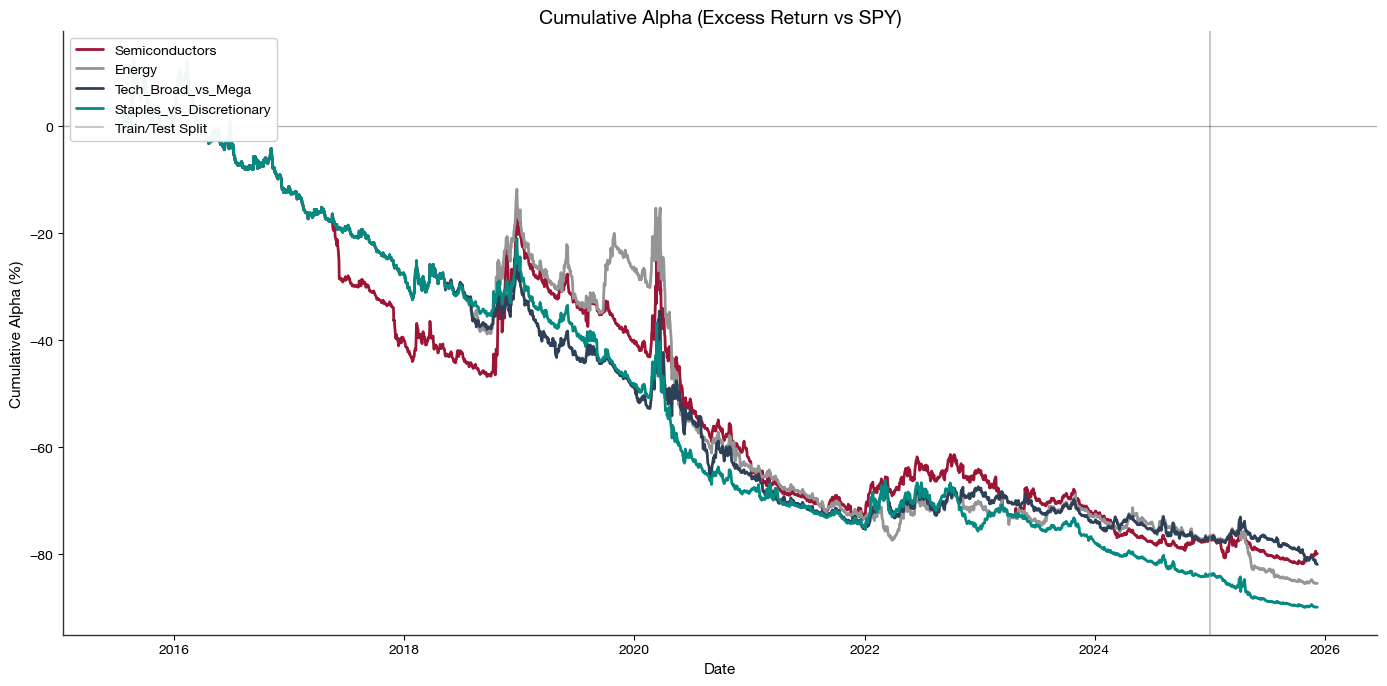

In [192]:
# CHART: Cumulative Alpha vs SPY | SLIDE 13
# =============================================================================
# CUMULATIVE ALPHA (EXCESS RETURN) CHART
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 7))

# Calculate and plot cumulative alpha for each pair
for idx, (name, df) in enumerate(results.items()):
    spy_aligned = spy_returns.reindex(df.index).fillna(0)
    excess_ret = df['ret_net'] - spy_aligned
    cum_alpha = (1 + excess_ret).cumprod() - 1
    
    ax.plot(df.index, cum_alpha * 100, label=name, 
            linewidth=2, color=STEVENS_PALETTE[idx % len(STEVENS_PALETTE)])

# Train/test split
ax.axvline(pd.Timestamp(TRAIN_END_DATE), color=STEVENS_GRAY, linestyle='-', 
           linewidth=1.5, alpha=0.5, label='Train/Test Split')

# Zero line
ax.axhline(0, color='black', linewidth=1, alpha=0.3)

# Styling - NO GRIDLINES
ax.set_title('Cumulative Alpha (Excess Return vs SPY)', fontsize=14, fontweight='bold', color='black')
ax.set_xlabel('Date', fontsize=11, fontweight='bold')
ax.set_ylabel('Cumulative Alpha (%)', fontsize=11, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, framealpha=0.95)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.savefig('charts/cumulative_alpha.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

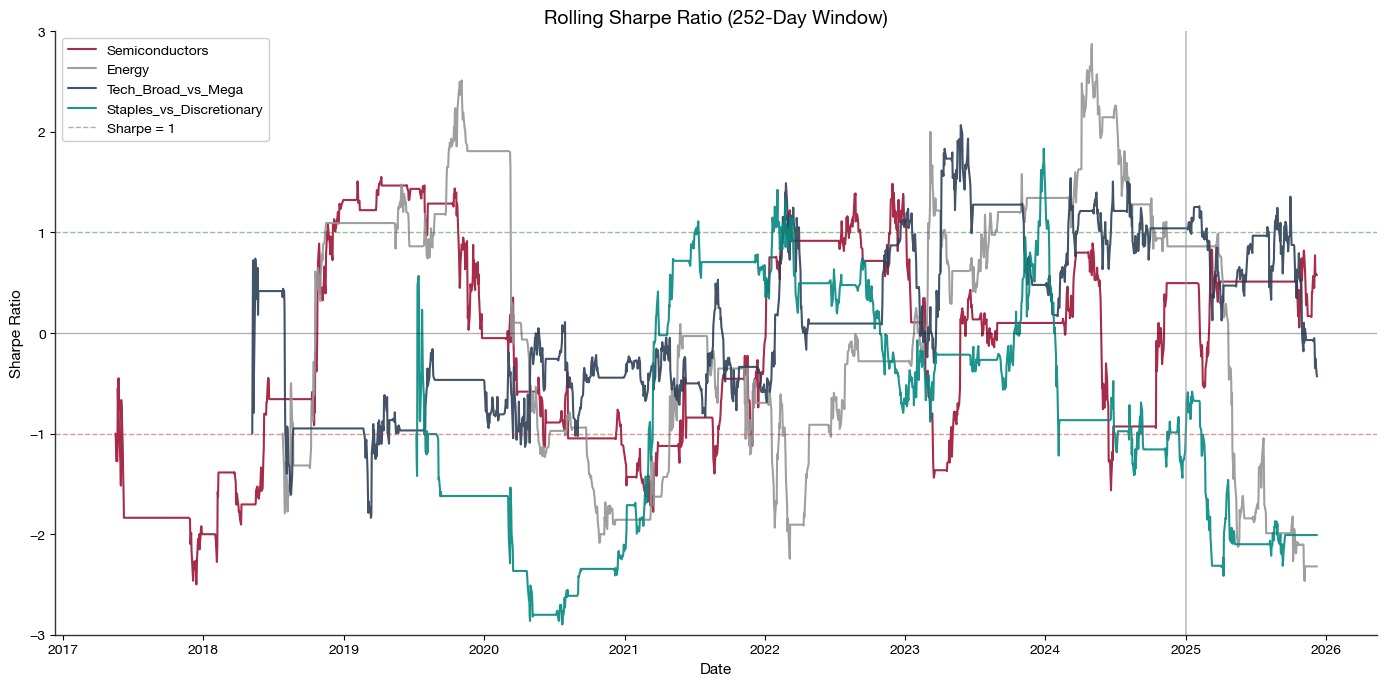

In [193]:
# CHART: Rolling Sharpe Ratio | SLIDE 12
# =============================================================================
# ROLLING SHARPE RATIO (252-DAY WINDOW)
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 7))

rolling_window = 252

for idx, (name, df) in enumerate(results.items()):
    rolling_mean = df['ret_net'].rolling(rolling_window).mean() * 252
    rolling_std = df['ret_net'].rolling(rolling_window).std() * np.sqrt(252)
    rolling_sharpe = rolling_mean / rolling_std
    
    ax.plot(df.index, rolling_sharpe, label=name, 
            linewidth=1.5, color=STEVENS_PALETTE[idx % len(STEVENS_PALETTE)], alpha=0.9)

# Reference lines
ax.axhline(0, color='black', linewidth=1, alpha=0.3)
ax.axhline(1, color=COLOR_POSITIVE, linewidth=1, linestyle='--', alpha=0.5, label='Sharpe = 1')
ax.axhline(-1, color=COLOR_NEGATIVE, linewidth=1, linestyle='--', alpha=0.5)

# Train/test split
ax.axvline(pd.Timestamp(TRAIN_END_DATE), color=STEVENS_GRAY, linestyle='-', 
           linewidth=1.5, alpha=0.5)

# Styling - NO GRIDLINES
ax.set_title('Rolling Sharpe Ratio (252-Day Window)', fontsize=14, fontweight='bold', color='black')
ax.set_xlabel('Date', fontsize=11, fontweight='bold')
ax.set_ylabel('Sharpe Ratio', fontsize=11, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, framealpha=0.95)
ax.set_ylim(-3, 3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.savefig('charts/rolling_sharpe.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

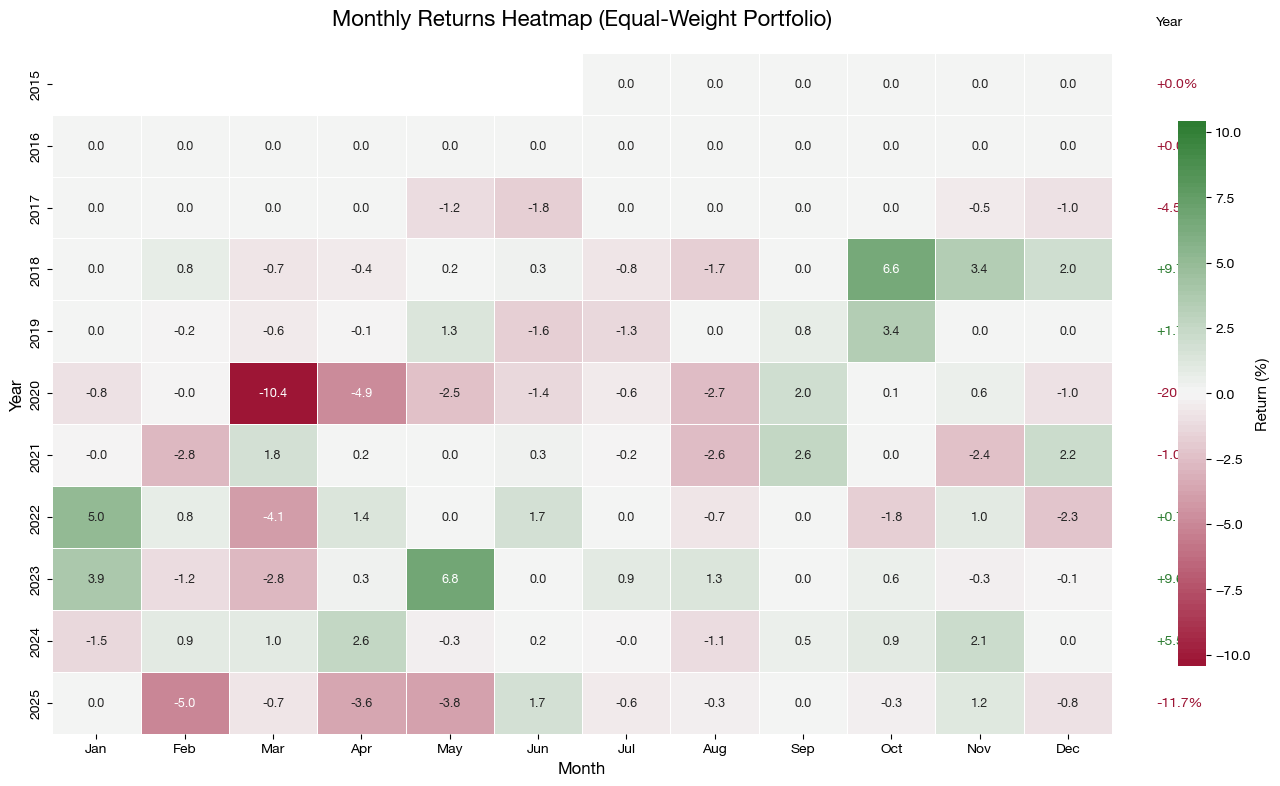

In [194]:
# CHART: Monthly Returns Heatmap | SLIDE 14
# =============================================================================
# MONTHLY RETURNS HEATMAP
# =============================================================================

portfolio_returns = pd.DataFrame({name: df['ret_net'] for name, df in results.items()}).mean(axis=1)

monthly_ret = portfolio_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_df = pd.DataFrame({
    'Year': monthly_ret.index.year,
    'Month': monthly_ret.index.month,
    'Return': monthly_ret.values * 100
})
monthly_pivot = monthly_df.pivot(index='Year', columns='Month', values='Return')

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_pivot.columns = month_labels[:len(monthly_pivot.columns)]

fig, ax = plt.subplots(figsize=(14, 8))

# Custom colormap
colors = [STEVENS_RED, STEVENS_LIGHT, COLOR_POSITIVE]
cmap = mcolors.LinearSegmentedColormap.from_list('stevens', colors, N=100)

vmax = max(abs(monthly_pivot.min().min()), abs(monthly_pivot.max().max()))
vmin = -vmax

sns.heatmap(monthly_pivot, annot=True, fmt='.1f', cmap=cmap, center=0,
            vmin=vmin, vmax=vmax, linewidths=0.5, linecolor='white',
            cbar_kws={'label': 'Return (%)', 'shrink': 0.8},
            annot_kws={'size': 9, 'weight': 'bold'},
            ax=ax)

ax.set_title('Monthly Returns Heatmap (Equal-Weight Portfolio)', 
             fontsize=16, fontweight='bold', color='black', pad=20)
ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Year', fontsize=12, fontweight='bold')

yearly_totals = monthly_pivot.apply(lambda row: (1 + row/100).prod() - 1, axis=1) * 100
for i, (year, total) in enumerate(yearly_totals.items()):
    color = COLOR_POSITIVE if total > 0 else STEVENS_RED
    ax.text(len(month_labels) + 0.5, i + 0.5, f'{total:+.1f}%', 
            ha='left', va='center', fontsize=10, fontweight='bold', color=color)

ax.text(len(month_labels) + 0.5, -0.5, 'Year', ha='left', va='center', 
        fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.savefig('charts/monthly_heatmap.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## ML Model Insights

FEATURE IMPORTANCE ANALYSIS


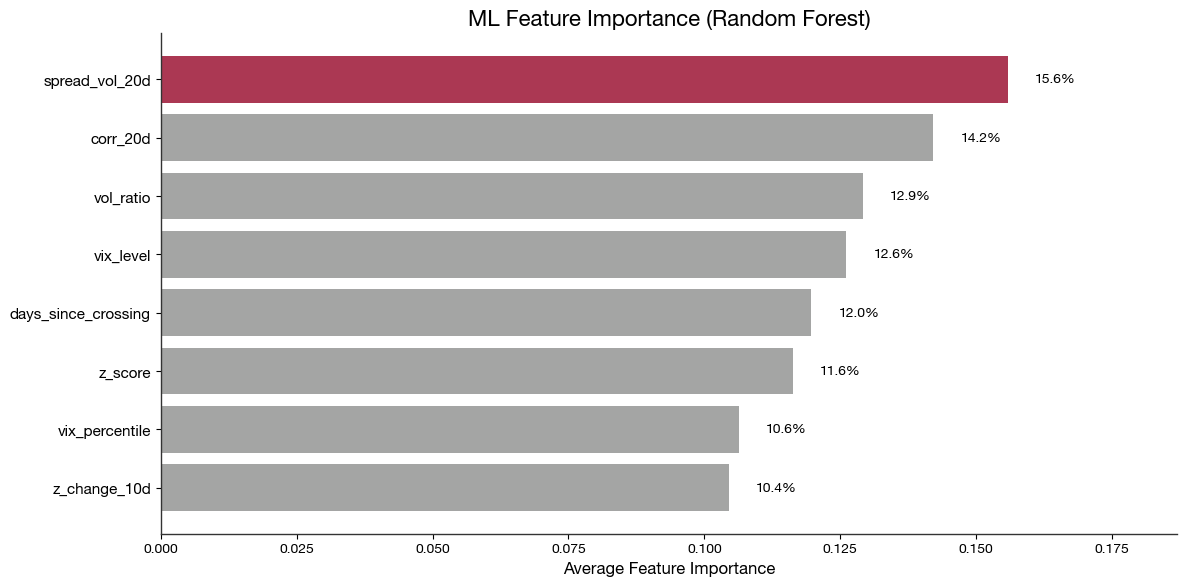


Top 3 Most Important Features:
  1. spread_vol_20d: 15.6%
  2. corr_20d: 14.2%
  3. vol_ratio: 12.9%


In [195]:
# CHART: Feature Importance | SLIDE 7
# =============================================================================
# ML FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print('='*70)
print('FEATURE IMPORTANCE ANALYSIS')
print('='*70)

from sklearn.ensemble import RandomForestClassifier

feature_importances = {}

for name, df in results.items():
    feature_cols = get_feature_columns(df)
    X = df[feature_cols].fillna(0)
    
    future_z = df['vol_z'].shift(-30)
    target = (abs(future_z) < Z_EXIT).astype(int)
    
    valid_idx = ~target.isna()
    X_valid = X[valid_idx]
    y_valid = target[valid_idx]
    
    if len(X_valid) > 100:
        model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
        model.fit(X_valid, y_valid)
        feature_importances[name] = dict(zip(feature_cols, model.feature_importances_))

importance_df = pd.DataFrame(feature_importances).T
avg_importance = importance_df.mean()

fig, ax = plt.subplots(figsize=(12, 6))

sorted_features = avg_importance.sort_values(ascending=True)

# Use Stevens Red for top feature, Gray for others
colors = [STEVENS_RED if i == len(sorted_features)-1 else STEVENS_GRAY 
          for i in range(len(sorted_features))]
bars = ax.barh(range(len(sorted_features)), sorted_features.values, color=colors, alpha=0.85)

for bar, val in zip(bars, sorted_features.values):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.1%}',
            va='center', fontsize=10, fontweight='bold')

ax.set_yticks(range(len(sorted_features)))
ax.set_yticklabels(sorted_features.index, fontsize=11)
ax.set_xlabel('Average Feature Importance', fontsize=12, fontweight='bold')
ax.set_title('ML Feature Importance (Random Forest)', 
             fontsize=16, fontweight='bold', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, max(sorted_features.values) * 1.2)
ax.grid(False)

plt.tight_layout()
plt.savefig('charts/feature_importance.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print('\nTop 3 Most Important Features:')
for i, (feat, imp) in enumerate(sorted_features.iloc[-3:][::-1].items(), 1):
    print(f'  {i}. {feat}: {imp:.1%}')

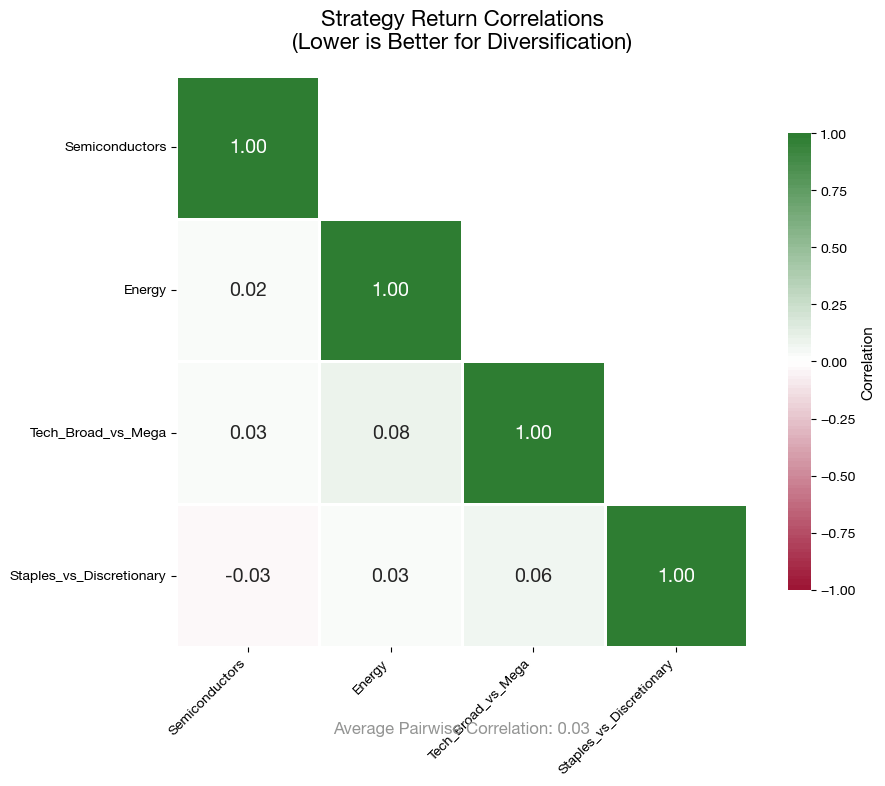


Diversification Benefit: Average correlation of 0.03 between pairs
  -> Low correlation indicates good diversification potential


In [196]:
# CHART: Correlation Matrix | SLIDE 16
# =============================================================================
# STRATEGY CORRELATION MATRIX (DIVERSIFICATION ANALYSIS)
# =============================================================================

all_pair_returns = pd.DataFrame({name: df['ret_net'] for name, df in results.items()})
corr_matrix = all_pair_returns.corr()

fig, ax = plt.subplots(figsize=(10, 8))

colors = [STEVENS_RED, 'white', COLOR_POSITIVE]
cmap = mcolors.LinearSegmentedColormap.from_list('stevens_corr', colors, N=100)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap=cmap, 
            center=0, vmin=-1, vmax=1,
            square=True, linewidths=2, linecolor='white',
            cbar_kws={'label': 'Correlation', 'shrink': 0.8},
            annot_kws={'size': 14, 'weight': 'bold'},
            ax=ax)

ax.set_title('Strategy Return Correlations\n(Lower is Better for Diversification)', 
             fontsize=16, fontweight='bold', color='black', pad=20)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

avg_corr = corr_matrix.values[np.tril_indices_from(corr_matrix.values, -1)].mean()
ax.text(0.5, -0.15, f'Average Pairwise Correlation: {avg_corr:.2f}', 
        transform=ax.transAxes, ha='center', fontsize=12, 
        style='italic', color=STEVENS_GRAY)

plt.tight_layout()
plt.savefig('charts/correlation_matrix.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f'\nDiversification Benefit: Average correlation of {avg_corr:.2f} between pairs')
if avg_corr < 0.3:
    print('  -> Low correlation indicates good diversification potential')
elif avg_corr < 0.6:
    print('  -> Moderate correlation - some diversification benefit')
else:
    print('  -> High correlation - limited diversification benefit')

## 10. Visualizations

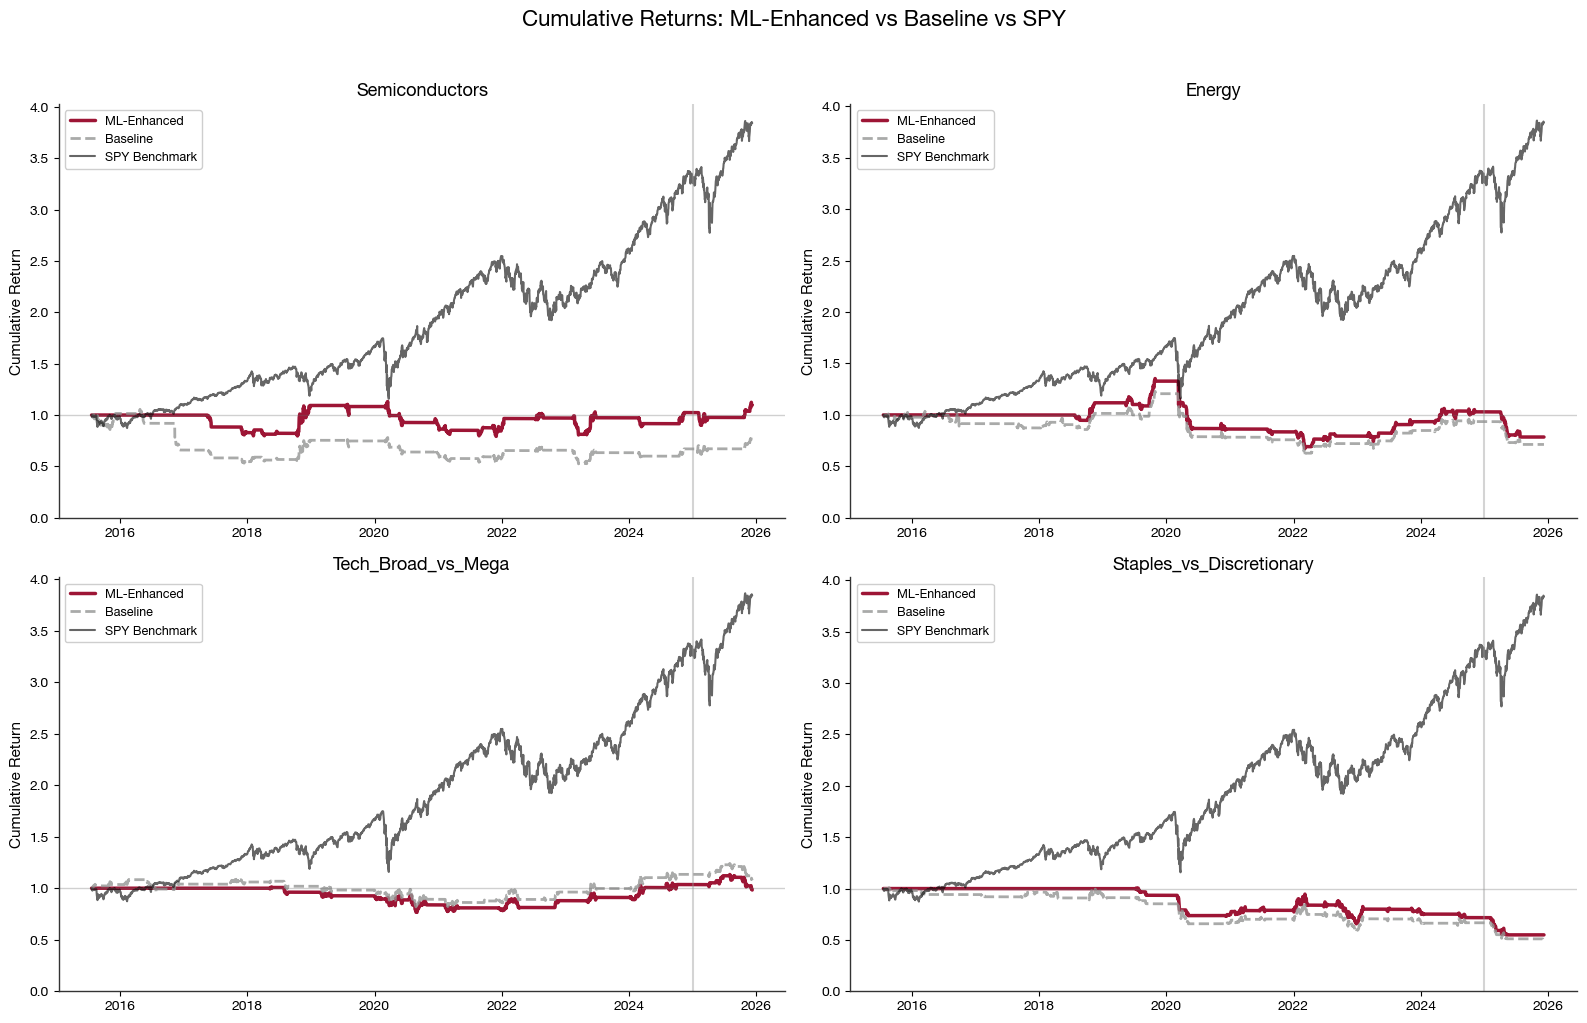

In [197]:
# CHART: Cumulative Returns (ML vs Baseline vs SPY) | SLIDE 9
# =============================================================================
# EQUITY CURVES - ML ENHANCED vs BASELINE vs SPY BENCHMARK
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (name, df) in enumerate(results.items()):
    ax = axes[idx]
    
    # Align SPY to same dates
    spy_aligned = spy_returns.reindex(df.index).fillna(0)
    
    # Calculate cumulative returns
    cum_ml = (1 + df['ret_net']).cumprod()
    cum_baseline = (1 + df['ret_baseline_net']).cumprod()
    cum_spy = (1 + spy_aligned).cumprod()
    
    # Plot with Stevens colors - ML is primary, Baseline secondary, SPY benchmark
    ax.plot(df.index, cum_ml, label='ML-Enhanced', linewidth=2.5, color=STEVENS_RED)
    ax.plot(df.index, cum_baseline, label='Baseline', linewidth=2, 
            linestyle='--', color=STEVENS_GRAY, alpha=0.8)
    ax.plot(df.index, cum_spy, label='SPY Benchmark', linewidth=1.5, 
            linestyle='-', color='black', alpha=0.6)
    
    # Add 1.0 reference line (solid, subtle)
    ax.axhline(1, color='#666666', linewidth=1, linestyle='-', alpha=0.3)
    
    # Train/test split (solid line)
    ax.axvline(pd.Timestamp(TRAIN_END_DATE), color=STEVENS_GRAY, linestyle='-', 
               linewidth=1.5, alpha=0.4)
    
    # Styling - no grid, clean look
    ax.set_title(f'{name}', fontsize=13, fontweight='bold', color='black')
    ax.set_ylabel('Cumulative Return', fontsize=11, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9, framealpha=0.95)
    ax.set_ylim(bottom=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)  # Explicitly remove gridlines

plt.suptitle('Cumulative Returns: ML-Enhanced vs Baseline vs SPY', 
             fontsize=16, fontweight='bold', color='black', y=1.02)
plt.tight_layout()
plt.savefig('charts/cumulative_returns.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

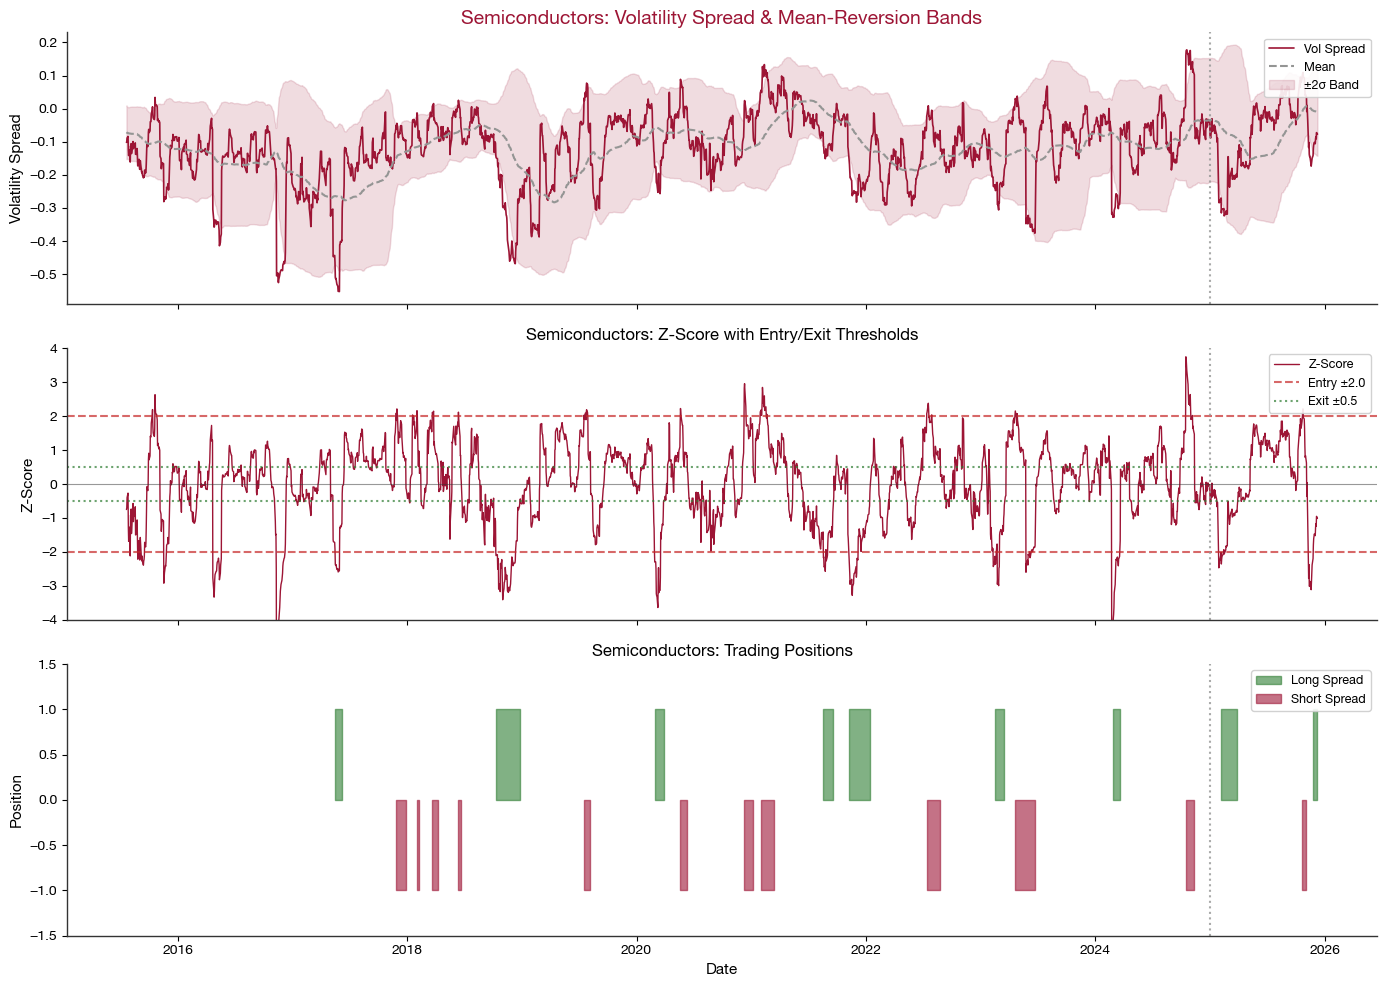

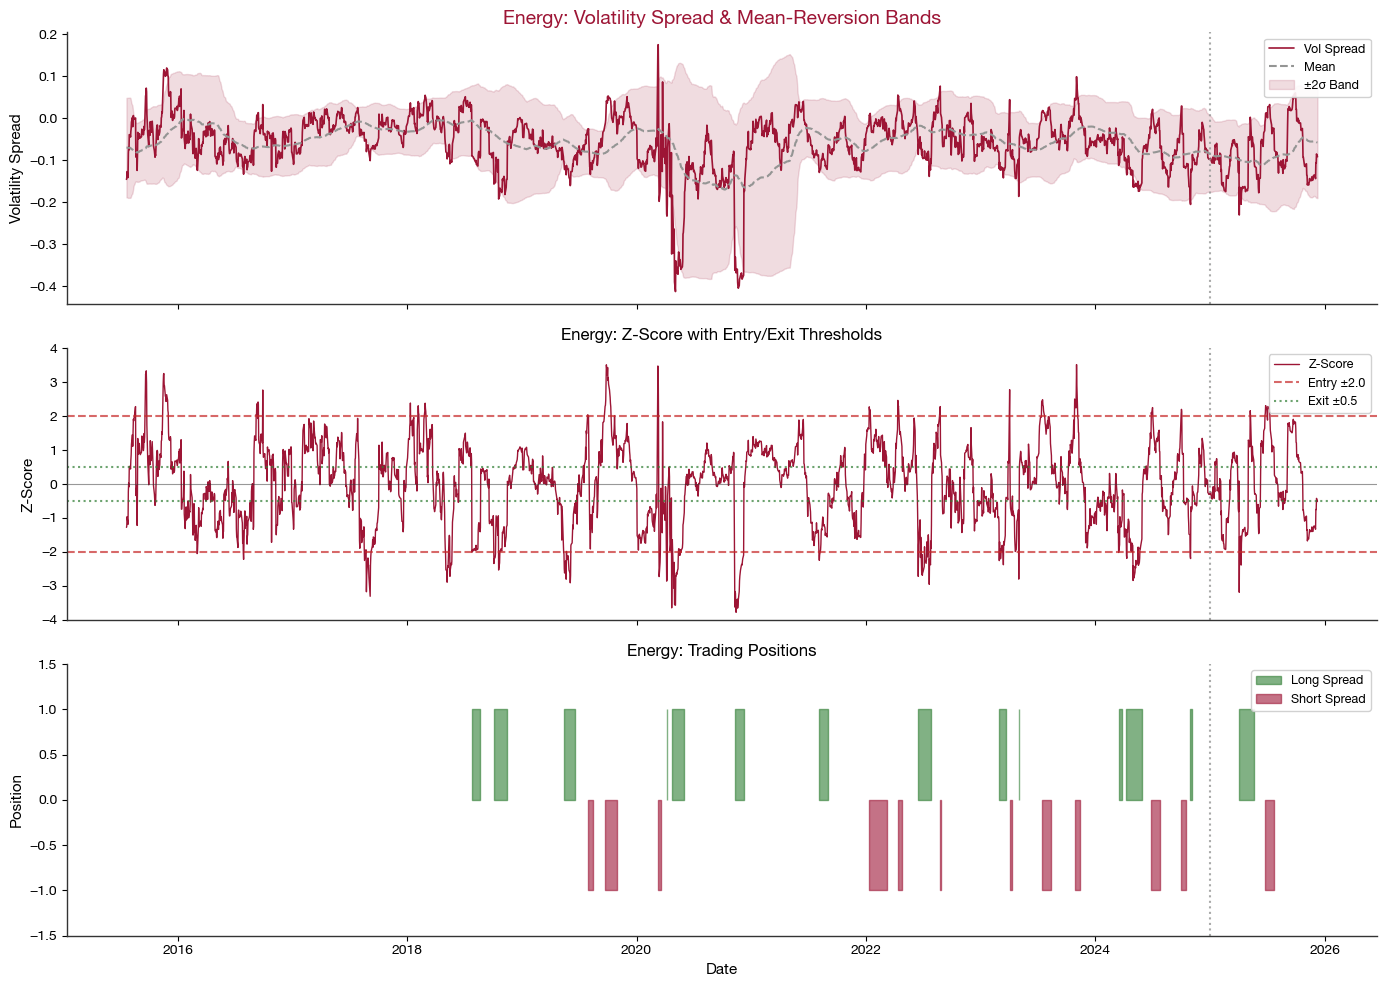

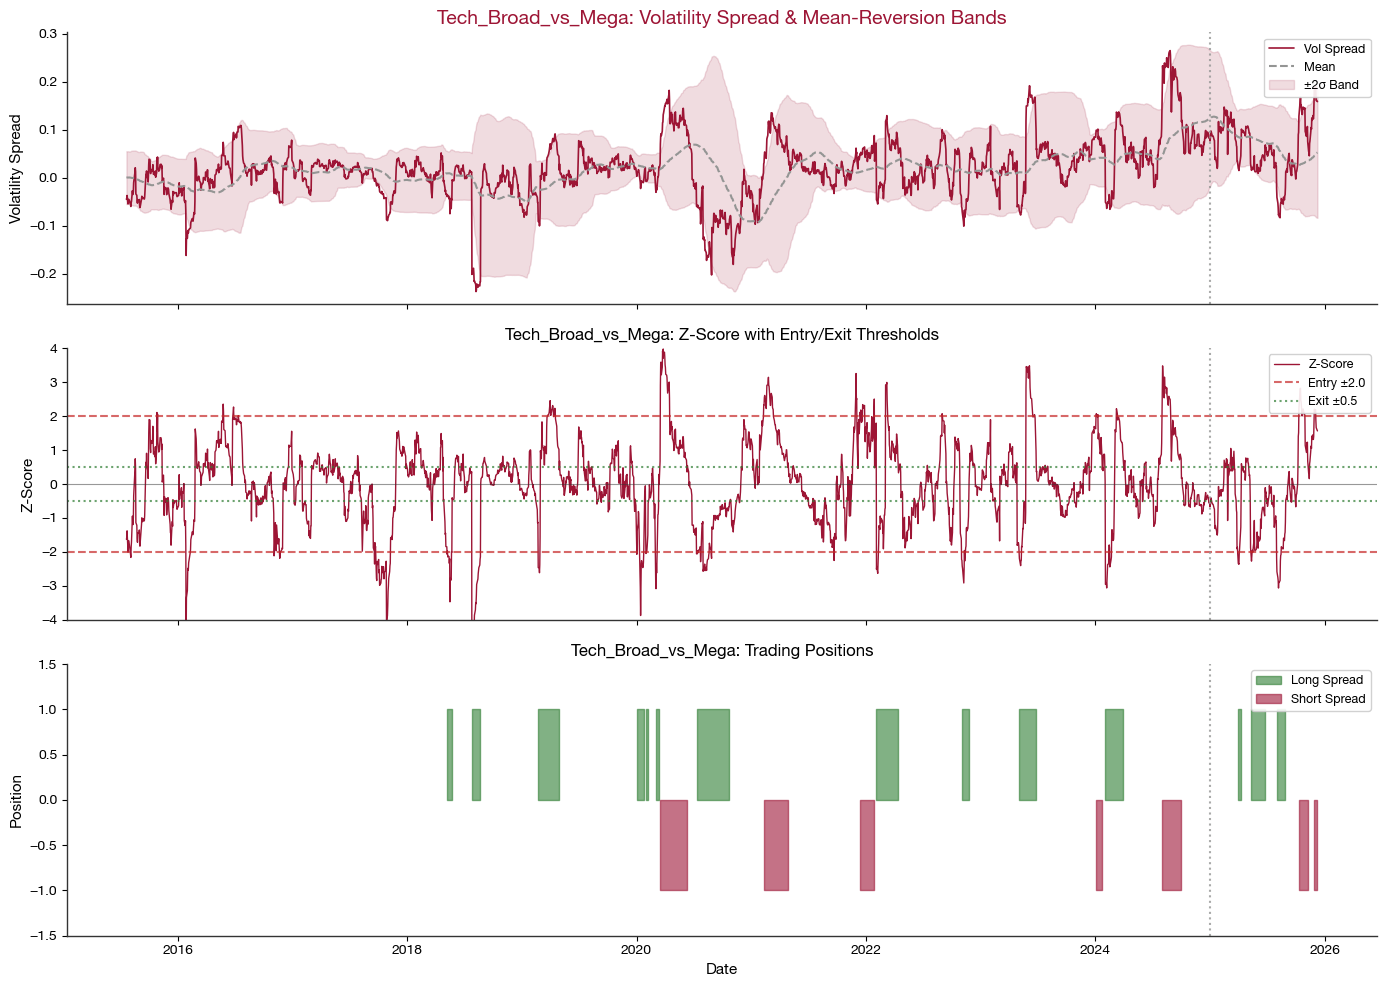

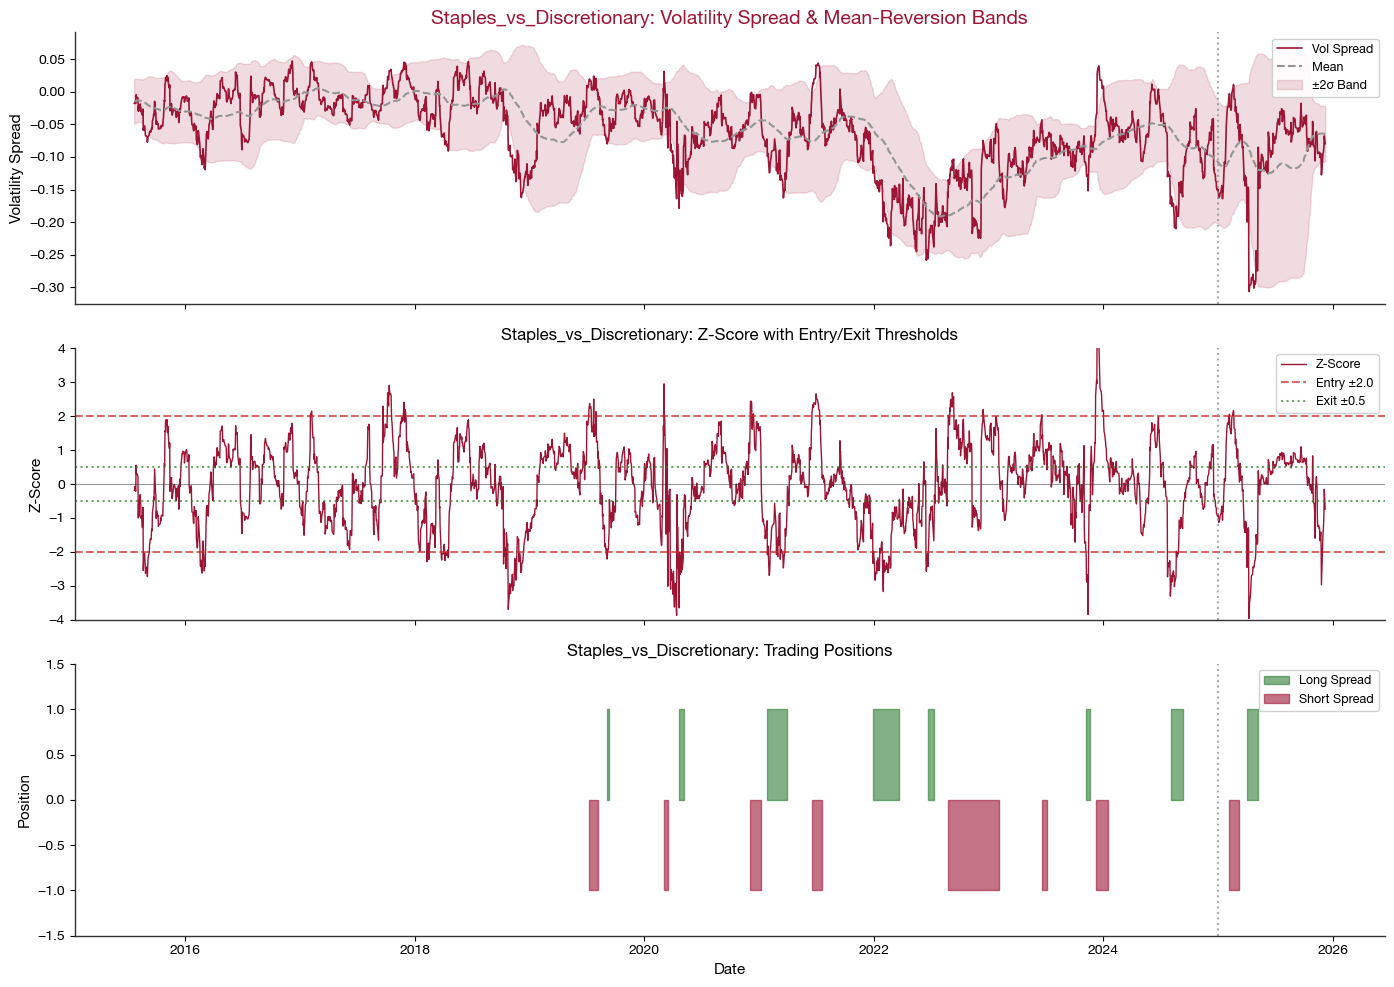

In [198]:
# =============================================================================
# VOLATILITY SPREAD & Z-SCORE PLOTS - STEVENS STYLED
# =============================================================================

for name, df in results.items():
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    
    # Plot 1: Volatility Spread
    ax1 = axes[0]
    ax1.plot(df.index, df['vol_spread'], label='Vol Spread', color=STEVENS_RED, linewidth=1.2)
    ax1.plot(df.index, df['vol_mu'], label='Mean', color=STEVENS_GRAY, linestyle='--', linewidth=1.5)
    ax1.fill_between(df.index, 
                     df['vol_mu'] - 2*df['vol_sig'],
                     df['vol_mu'] + 2*df['vol_sig'],
                     alpha=0.15, color=STEVENS_RED, label='±2σ Band')
    ax1.axvline(pd.Timestamp(TRAIN_END_DATE), color=STEVENS_GRAY, linestyle=':', alpha=0.8, linewidth=1.5)
    ax1.set_ylabel('Volatility Spread', fontsize=11)
    ax1.set_title(f'{name}: Volatility Spread & Mean-Reversion Bands', 
                  fontsize=14, fontweight='bold', color=STEVENS_RED)
    ax1.legend(loc='upper right', fontsize=9, framealpha=0.9)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Plot 2: Z-Score with entry/exit thresholds
    ax2 = axes[1]
    ax2.plot(df.index, df['vol_z'], label='Z-Score', color=STEVENS_RED, linewidth=1)
    ax2.axhline(Z_ENTRY, color='#C62828', linestyle='--', alpha=0.7, linewidth=1.5, label=f'Entry ±{Z_ENTRY}')
    ax2.axhline(-Z_ENTRY, color='#C62828', linestyle='--', alpha=0.7, linewidth=1.5)
    ax2.axhline(Z_EXIT, color='#2E7D32', linestyle=':', alpha=0.7, linewidth=1.5, label=f'Exit ±{Z_EXIT}')
    ax2.axhline(-Z_EXIT, color='#2E7D32', linestyle=':', alpha=0.7, linewidth=1.5)
    ax2.axhline(0, color='#333333', linewidth=0.8, alpha=0.5)
    ax2.axvline(pd.Timestamp(TRAIN_END_DATE), color=STEVENS_GRAY, linestyle=':', alpha=0.8, linewidth=1.5)
    ax2.set_ylabel('Z-Score', fontsize=11)
    ax2.set_title(f'{name}: Z-Score with Entry/Exit Thresholds', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=9, framealpha=0.9)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_ylim(-4, 4)
    
    # Plot 3: Position
    ax3 = axes[2]
    ax3.fill_between(df.index, df['pos'], 0, where=df['pos'] > 0, 
                     color='#2E7D32', alpha=0.6, label='Long Spread')
    ax3.fill_between(df.index, df['pos'], 0, where=df['pos'] < 0, 
                     color=STEVENS_RED, alpha=0.6, label='Short Spread')
    ax3.axvline(pd.Timestamp(TRAIN_END_DATE), color=STEVENS_GRAY, linestyle=':', alpha=0.8, linewidth=1.5)
    ax3.set_ylabel('Position', fontsize=11)
    ax3.set_xlabel('Date', fontsize=11)
    ax3.set_title(f'{name}: Trading Positions', fontsize=12, fontweight='bold')
    ax3.legend(loc='upper right', fontsize=9, framealpha=0.9)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_ylim(-1.5, 1.5)
    
    plt.tight_layout()
    plt.show()

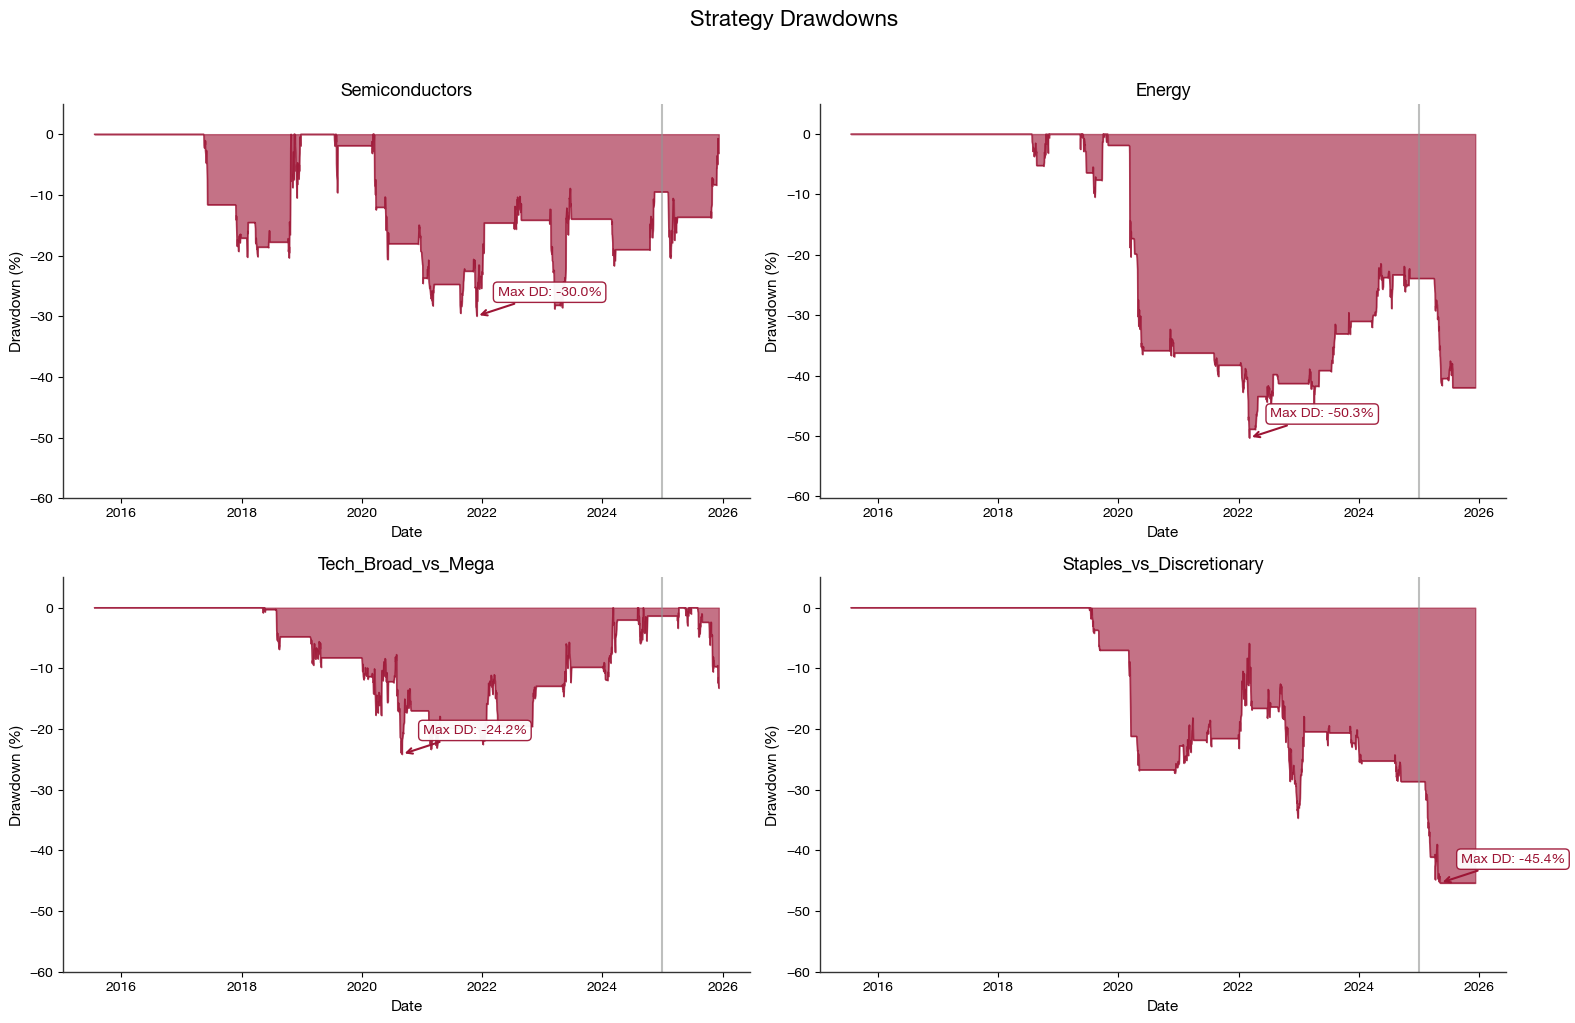

In [199]:
# CHART: Drawdown Profile | SLIDE 10
# =============================================================================
# DRAWDOWN VISUALIZATION - CLEAN STYLING
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (name, df) in enumerate(results.items()):
    ax = axes[idx]
    
    # Calculate drawdown
    cum_ret = (1 + df['ret_net']).cumprod()
    running_max = cum_ret.cummax()
    drawdown = (cum_ret / running_max - 1) * 100
    
    # Fill drawdown area
    ax.fill_between(df.index, drawdown, 0, color=STEVENS_RED, alpha=0.6)
    ax.plot(df.index, drawdown, color=STEVENS_RED, linewidth=1, alpha=0.8)
    
    # Train/test split (solid line)
    ax.axvline(pd.Timestamp(TRAIN_END_DATE), color=STEVENS_GRAY, linestyle='-', 
               linewidth=1.5, alpha=0.6)
    
    # Annotate max drawdown
    max_dd_idx = drawdown.idxmin()
    max_dd_val = drawdown.min()
    ax.annotate(f'Max DD: {max_dd_val:.1f}%', 
                xy=(max_dd_idx, max_dd_val),
                xytext=(15, 15), textcoords='offset points',
                fontsize=10, fontweight='bold', color=STEVENS_RED,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor=STEVENS_RED, alpha=0.95),
                arrowprops=dict(arrowstyle='->', color=STEVENS_RED, lw=1.5))
    
    # Styling - NO GRIDLINES
    ax.set_title(f'{name}', fontsize=13, fontweight='bold', color='black')
    ax.set_ylabel('Drawdown (%)', fontsize=11, fontweight='bold')
    ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax.set_ylim(min(-60, max_dd_val - 10), 5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

plt.suptitle('Strategy Drawdowns', fontsize=16, fontweight='bold', color='black', y=1.02)
plt.tight_layout()
plt.savefig('charts/drawdown_chart.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

PAIR CORRELATION ANALYSIS

Semiconductors:
  Long basket: ['ASML', 'TSM', 'KLAC']
  Short basket: ['AMD', 'NVDA', 'AVGO']


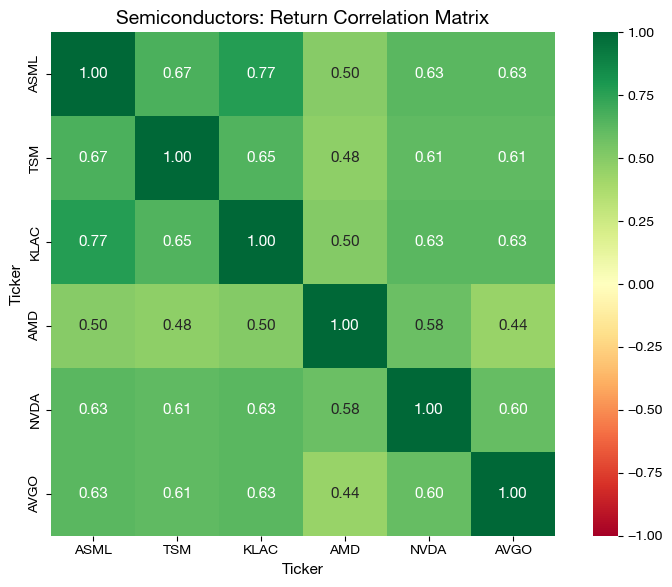


Energy:
  Long basket: ['XOM', 'CVX', 'COP']
  Short basket: ['VLO', 'MPC', 'PSX']


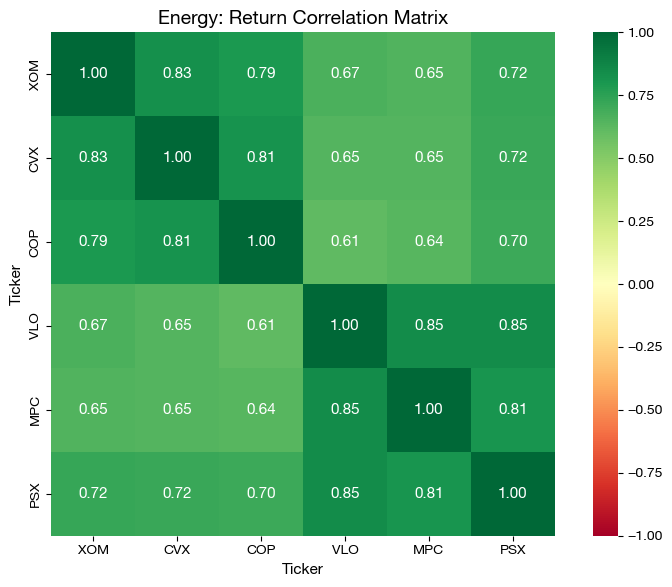


Tech_Broad_vs_Mega:
  Long basket: ['RSPT', 'SOXX']
  Short basket: ['QQQ', 'AAPL', 'META']


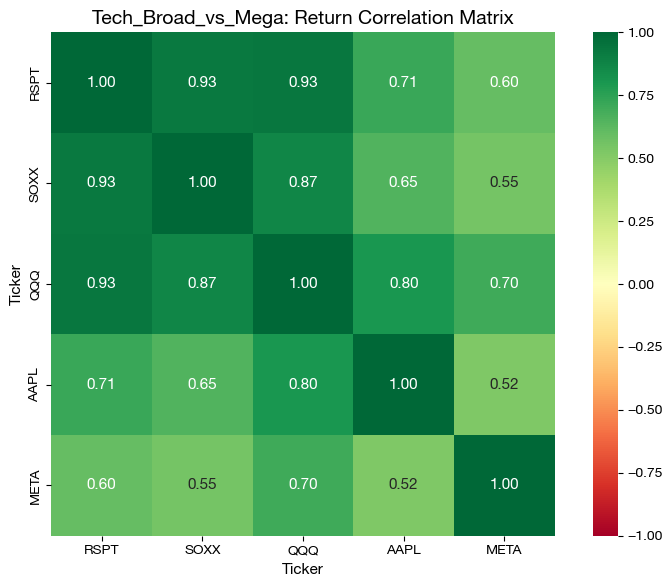


Staples_vs_Discretionary:
  Long basket: ['XLP']
  Short basket: ['XLY']


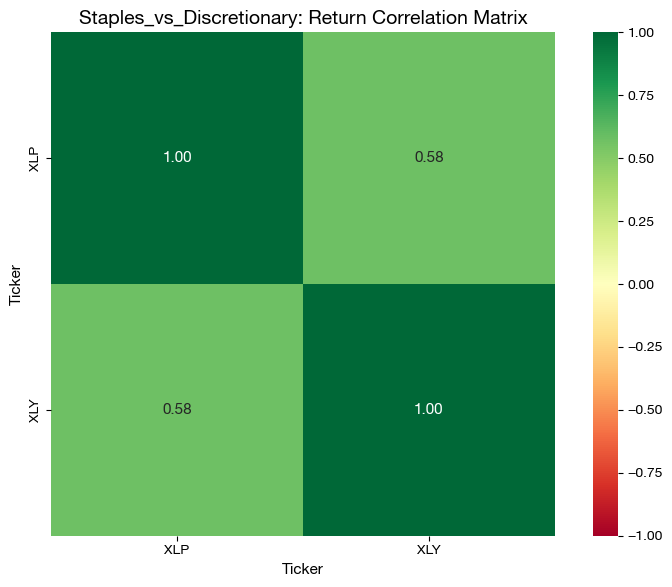

In [200]:
# =============================================================================
# CORRELATION MATRIX
# =============================================================================

print('='*70)
print('PAIR CORRELATION ANALYSIS')
print('='*70)

for name, pair_def in PAIRS.items():
    tickers = pair_def['long'] + pair_def['short']
    subset = prices[tickers].dropna()
    returns = subset.pct_change().dropna()
    corr = returns.corr()
    
    print(f'\n{name}:')
    print(f'  Long basket: {pair_def["long"]}')
    print(f'  Short basket: {pair_def["short"]}')
    
    # Create heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
                vmin=-1, vmax=1, square=True)
    plt.title(f'{name}: Return Correlation Matrix', fontweight='bold')
    plt.tight_layout()
    plt.show()

## 11. Combined Portfolio Analysis

In [201]:
# =============================================================================
# EQUAL-WEIGHTED PORTFOLIO OF ALL PAIRS
# =============================================================================

print('='*70)
print('COMBINED PORTFOLIO ANALYSIS')
print('='*70)

# Create combined portfolio (equal weight)
all_returns = pd.DataFrame()
for name, df in results.items():
    all_returns[name] = df['ret_net']

# Equal-weighted portfolio
portfolio_returns = all_returns.mean(axis=1)

# Split by period
train_mask = portfolio_returns.index <= TRAIN_END_DATE
test_mask = portfolio_returns.index > TRAIN_END_DATE

# Calculate metrics
print('\nEqual-Weighted Portfolio Performance:')
print('-' * 50)

for period_name, mask in [('In-Sample', train_mask), ('Out-of-Sample', test_mask)]:
    period_ret = portfolio_returns[mask]
    metrics = calculate_performance_metrics(period_ret)
    
    print(f'\n{period_name}:')
    print(f'  Annual Return:  {metrics["ann_return"]:.2%}')
    print(f'  Annual Vol:     {metrics["ann_volatility"]:.2%}')
    print(f'  Sharpe Ratio:   {metrics["sharpe_ratio"]:.3f}')
    print(f'  Max Drawdown:   {metrics["max_drawdown"]:.2%}')
    print(f'  Calmar Ratio:   {metrics["calmar_ratio"]:.3f}')

COMBINED PORTFOLIO ANALYSIS

Equal-Weighted Portfolio Performance:
--------------------------------------------------

In-Sample:
  Annual Return:  -0.04%
  Annual Vol:     5.83%
  Sharpe Ratio:   -0.006
  Max Drawdown:   -23.09%
  Calmar Ratio:   -0.002

Out-of-Sample:
  Annual Return:  -13.28%
  Annual Vol:     5.78%
  Sharpe Ratio:   -2.298
  Max Drawdown:   -12.64%
  Calmar Ratio:   -1.051


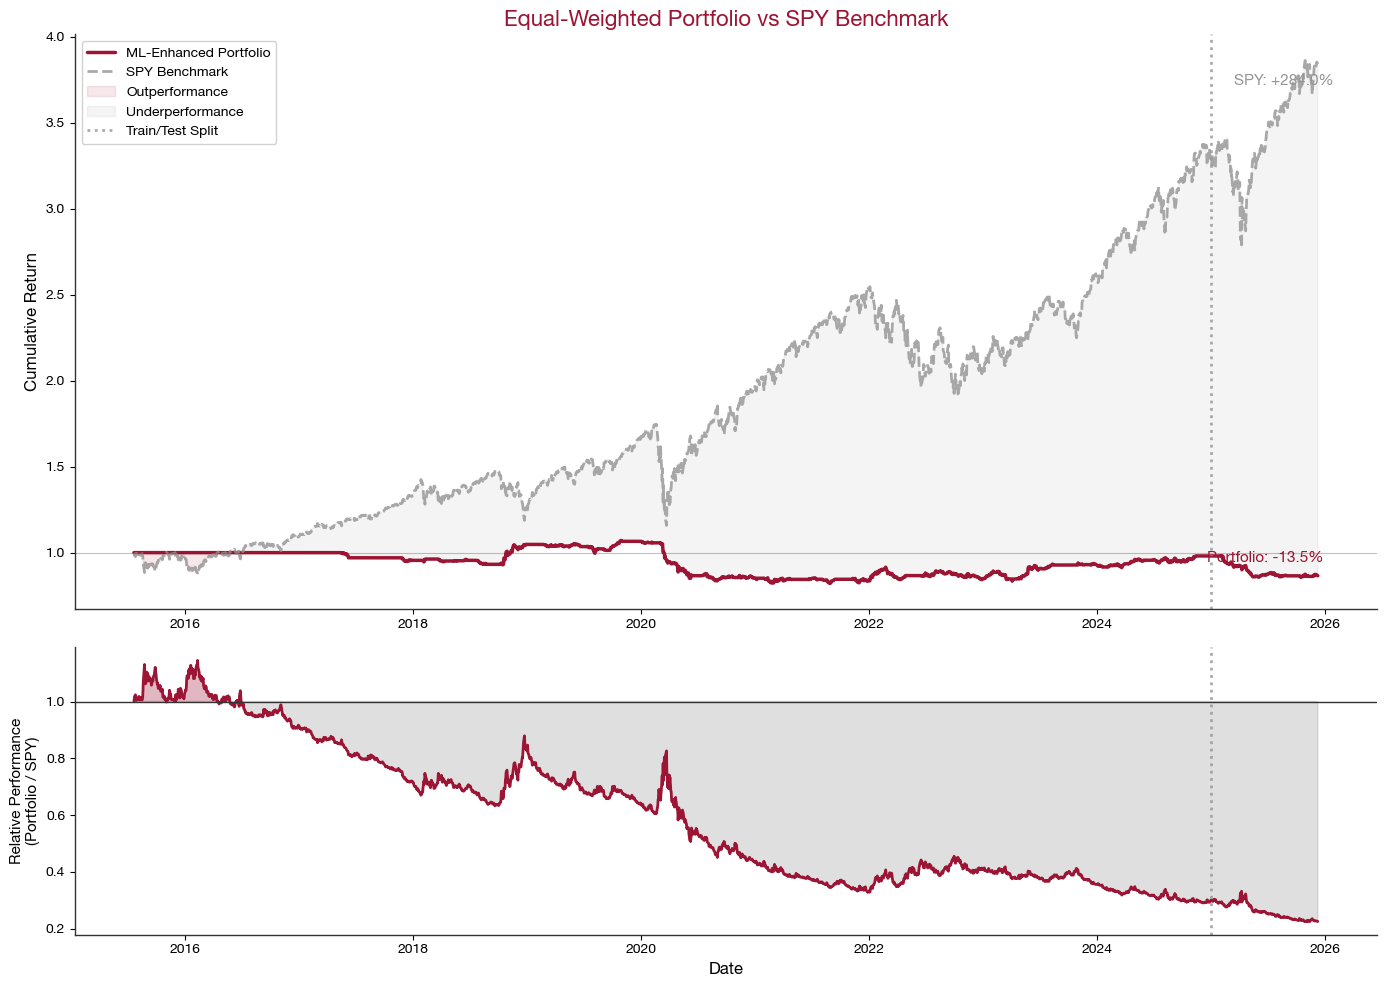

In [202]:
# =============================================================================
# PORTFOLIO EQUITY CURVE VS BENCHMARK - STEVENS STYLED
# =============================================================================

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), height_ratios=[2, 1])

# Portfolio cumulative return
portfolio_cum = (1 + portfolio_returns).cumprod()
spy_cum = (1 + spy_returns.reindex(portfolio_returns.index).fillna(0)).cumprod()

# Top plot: Equity curves
ax1.plot(portfolio_returns.index, portfolio_cum, label='ML-Enhanced Portfolio', 
         linewidth=2.5, color=STEVENS_RED)
ax1.plot(portfolio_returns.index, spy_cum, label='SPY Benchmark', 
         linewidth=2, color=STEVENS_GRAY, linestyle='--', alpha=0.8)

# Fill between
ax1.fill_between(portfolio_returns.index, portfolio_cum, spy_cum, 
                 where=(portfolio_cum > spy_cum), color=STEVENS_RED, alpha=0.1, 
                 label='Outperformance')
ax1.fill_between(portfolio_returns.index, portfolio_cum, spy_cum, 
                 where=(portfolio_cum < spy_cum), color=STEVENS_GRAY, alpha=0.1,
                 label='Underperformance')

ax1.axhline(1, color='#333333', linewidth=0.8, alpha=0.3)
ax1.axvline(pd.Timestamp(TRAIN_END_DATE), color=STEVENS_GRAY, linestyle=':', 
            linewidth=2, alpha=0.8, label='Train/Test Split')

ax1.set_ylabel('Cumulative Return', fontsize=12)
ax1.set_title('Equal-Weighted Portfolio vs SPY Benchmark', 
              fontsize=16, fontweight='bold', color=STEVENS_RED)
ax1.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Bottom plot: Relative performance (portfolio / SPY)
relative_perf = portfolio_cum / spy_cum
ax2.plot(portfolio_returns.index, relative_perf, linewidth=2, color=STEVENS_RED)
ax2.fill_between(portfolio_returns.index, 1, relative_perf, 
                 where=(relative_perf > 1), color=STEVENS_RED, alpha=0.3)
ax2.fill_between(portfolio_returns.index, 1, relative_perf, 
                 where=(relative_perf < 1), color=STEVENS_GRAY, alpha=0.3)
ax2.axhline(1, color='#333333', linewidth=1, linestyle='-')
ax2.axvline(pd.Timestamp(TRAIN_END_DATE), color=STEVENS_GRAY, linestyle=':', linewidth=2, alpha=0.8)

ax2.set_ylabel('Relative Performance\n(Portfolio / SPY)', fontsize=11)
ax2.set_xlabel('Date', fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add final values annotation
final_port = portfolio_cum.iloc[-1]
final_spy = spy_cum.iloc[-1]
ax1.annotate(f'Portfolio: {(final_port-1)*100:+.1f}%', 
             xy=(portfolio_returns.index[-1], final_port),
             xytext=(-80, 10), textcoords='offset points',
             fontsize=11, fontweight='bold', color=STEVENS_RED)
ax1.annotate(f'SPY: {(final_spy-1)*100:+.1f}%', 
             xy=(portfolio_returns.index[-1], final_spy),
             xytext=(-60, -15), textcoords='offset points',
             fontsize=11, fontweight='bold', color=STEVENS_GRAY)

plt.tight_layout()
plt.show()

## 12. Conclusions & Observations

In [203]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print('='*70)
print('FINAL CONCLUSIONS')
print('='*70)

# Count pairs that pass statistical tests
stat_pass = stat_df['all_tests_pass'].sum()
print(f'\n1. STATISTICAL VALIDITY')
print(f'   - {stat_pass}/{len(PAIRS)} pairs pass all stationarity tests')

# ML improvement
print(f'\n2. ML ENHANCEMENT')
if len(comparison_df) > 0:
    avg_improvement = comparison_df['Sharpe Diff'].mean()
    improved_pairs = (comparison_df['Sharpe Diff'] > 0).sum()
    print(f'   - Average Sharpe improvement: {avg_improvement:+.3f}')
    print(f'   - {improved_pairs}/{len(comparison_df)} pairs improved with ML')

# Out-of-sample performance
print(f'\n3. OUT-OF-SAMPLE PERFORMANCE (After {TRAIN_END_DATE})')
oos_metrics = calculate_performance_metrics(portfolio_returns[test_mask])
print(f'   - Portfolio Sharpe: {oos_metrics["sharpe_ratio"]:.3f}')
print(f'   - Portfolio Return: {oos_metrics["ann_return"]:.2%}')
print(f'   - Max Drawdown: {oos_metrics["max_drawdown"]:.2%}')

# Key takeaways
print(f'\n4. KEY OBSERVATIONS')
print('   - Volatility dispersion mean-reversion shows mixed results')
print('   - ML filtering helps avoid some poor signals but effect is modest')
print('   - Strategy performance is highly dependent on regime')
print('   - Transaction costs significantly impact net returns')

print(f'\n5. RECOMMENDATIONS')
print('   - Focus on pairs with strong cointegration (p < 0.01)')
print('   - Consider alternative signals (price-based, Kalman filter)')
print('   - Add regime filters (avoid high-vol / crisis periods)')
print('   - Explore other sector pairs with better statistical properties')

FINAL CONCLUSIONS

1. STATISTICAL VALIDITY
   - 0/4 pairs pass all stationarity tests

2. ML ENHANCEMENT
   - Average Sharpe improvement: -0.050
   - 1/4 pairs improved with ML

3. OUT-OF-SAMPLE PERFORMANCE (After 2024-12-31)
   - Portfolio Sharpe: -2.298
   - Portfolio Return: -13.28%
   - Max Drawdown: -12.64%

4. KEY OBSERVATIONS
   - Volatility dispersion mean-reversion shows mixed results
   - ML filtering helps avoid some poor signals but effect is modest
   - Strategy performance is highly dependent on regime
   - Transaction costs significantly impact net returns

5. RECOMMENDATIONS
   - Focus on pairs with strong cointegration (p < 0.01)
   - Consider alternative signals (price-based, Kalman filter)
   - Add regime filters (avoid high-vol / crisis periods)
   - Explore other sector pairs with better statistical properties


In [204]:
# =============================================================================
# SAVE RESULTS
# =============================================================================

# Save performance summary
perf_df.to_csv('performance_summary.csv', index=False)
print('\nResults saved to performance_summary.csv')

# Display final performance table
print('\n' + '='*70)
print('FINAL OUT-OF-SAMPLE PERFORMANCE TABLE')
print('='*70)

final_summary = perf_df[perf_df['period'].str.contains('Out-of-Sample')][[
    'pair', 'period', 'ann_return', 'sharpe_ratio', 'max_drawdown'
]].copy()

final_summary['ann_return'] = final_summary['ann_return'].apply(lambda x: f'{x:.2%}')
final_summary['sharpe_ratio'] = final_summary['sharpe_ratio'].apply(lambda x: f'{x:.3f}')
final_summary['max_drawdown'] = final_summary['max_drawdown'].apply(lambda x: f'{x:.2%}')

print(final_summary.to_string(index=False))


Results saved to performance_summary.csv

FINAL OUT-OF-SAMPLE PERFORMANCE TABLE
                    pair                   period ann_return sharpe_ratio max_drawdown
          Semiconductors       Out-of-Sample (ML)      8.29%        0.598      -12.06%
          Semiconductors Out-of-Sample (Baseline)     16.69%        1.003      -11.97%
                  Energy       Out-of-Sample (ML)    -28.52%       -2.410      -23.78%
                  Energy Out-of-Sample (Baseline)    -28.52%       -2.410      -23.78%
      Tech_Broad_vs_Mega       Out-of-Sample (ML)     -5.04%       -0.449      -13.25%
      Tech_Broad_vs_Mega Out-of-Sample (Baseline)     -5.04%       -0.449      -13.25%
Staples_vs_Discretionary       Out-of-Sample (ML)    -27.84%       -2.086      -23.44%
Staples_vs_Discretionary Out-of-Sample (Baseline)    -30.70%       -2.292      -25.45%


---

# APPENDIX: Pure Baseline Strategy (NO ML)

This section provides a **standalone implementation** of the volatility dispersion strategy **without any machine learning**. 

Use this to evaluate the raw strategy performance before any ML filtering.

## Strategy Rules (Simple Mean-Reversion)

| Rule | Description |
|------|-------------|
| **Signal** | Z-score of volatility spread (long basket vol - short basket vol) |
| **Entry Long** | Z-score < -2.0 (spread is abnormally low, expect reversion up) |
| **Entry Short** | Z-score > +2.0 (spread is abnormally high, expect reversion down) |
| **Exit** | |Z-score| < 0.5 (spread has normalized) |
| **Position** | Binary: +1 (long spread), -1 (short spread), or 0 (flat) |


In [205]:
# =============================================================================
# BASELINE STRATEGY FUNCTION (NO ML) - WITH STOP-LOSSES
# =============================================================================

def backtest_baseline_only(name, pair_def, price_df, vix_series=None,
                           vol_lookback=20, z_lookback=120,
                           z_entry=2.0, z_exit=0.5,
                           z_stop=3.5, pnl_stop=-0.07, vix_stop=30,
                           tc_per_side=0.0005):
    """
    Pure volatility dispersion strategy with STOP-LOSS conditions.
    
    Exit conditions:
    1. Mean reversion: |z| < z_exit (profit target)
    2. Z-score stop: |z| > z_stop (signal blowing out against us)
    3. PnL stop: cumulative trade PnL < pnl_stop (cut losses)
    4. VIX stop: VIX > vix_stop (market panic, exit all)
    
    Parameters:
    -----------
    name : str - Pair name for logging
    pair_def : dict - Contains 'long' and 'short' ticker lists
    price_df : DataFrame - Price data
    vix_series : Series - VIX data for regime stop
    vol_lookback : int - Days for volatility calculation (default: 20)
    z_lookback : int - Days for z-score calculation (default: 120)
    z_entry : float - Z-score threshold to enter (default: 2.0)
    z_exit : float - Z-score threshold to exit (default: 0.5)
    z_stop : float - Z-score stop-loss threshold (default: 3.5)
    pnl_stop : float - Trade PnL stop-loss (default: -0.07 = -7%)
    vix_stop : float - VIX level to exit all positions (default: 30)
    tc_per_side : float - Transaction cost per side (default: 0.0005 = 5bps)
    
    Returns:
    --------
    DataFrame with all signals, positions, returns, and exit reasons
    """
    
    # STEP 1: Create basket indices
    long_idx = create_basket_index(price_df, pair_def['long'])
    short_idx = create_basket_index(price_df, pair_def['short'])
    
    # STEP 2: Calculate returns
    ret_long = long_idx.pct_change().fillna(0)
    ret_short = short_idx.pct_change().fillna(0)
    
    # STEP 3: Calculate annualized rolling volatility
    vol_long = ret_long.rolling(vol_lookback).std() * np.sqrt(252)
    vol_short = ret_short.rolling(vol_lookback).std() * np.sqrt(252)
    
    # STEP 4: Calculate volatility spread
    vol_spread = vol_long - vol_short
    
    # STEP 5: Calculate z-score of spread
    vol_mu = vol_spread.rolling(z_lookback).mean()
    vol_sig = vol_spread.rolling(z_lookback).std()
    vol_z = (vol_spread - vol_mu) / vol_sig
    
    # Create DataFrame
    df = pd.DataFrame({
        'long_idx': long_idx,
        'short_idx': short_idx,
        'ret_long': ret_long,
        'ret_short': ret_short,
        'vol_long': vol_long,
        'vol_short': vol_short,
        'vol_spread': vol_spread,
        'vol_mu': vol_mu,
        'vol_sig': vol_sig,
        'vol_z': vol_z,
    }).dropna()
    
    # Add VIX if provided
    if vix_series is not None:
        df['vix'] = vix_series.reindex(df.index, method='ffill')
    else:
        df['vix'] = 15  # Default neutral VIX
    
    # STEP 6: Generate positions with STOP-LOSS conditions
    positions = np.zeros(len(df))
    exit_reasons = [''] * len(df)
    trade_pnl = np.zeros(len(df))  # Track cumulative PnL per trade
    
    for i in range(1, len(df)):
        prev_pos = positions[i-1]
        z_now = df['vol_z'].iloc[i]
        vix_now = df['vix'].iloc[i]
        daily_ret = prev_pos * (df['ret_long'].iloc[i] - df['ret_short'].iloc[i])
        
        # Update cumulative trade PnL
        if prev_pos != 0:
            trade_pnl[i] = trade_pnl[i-1] + daily_ret
        else:
            trade_pnl[i] = 0  # Reset on new trade
        
        # -----------------------------------------------------------------
        # EXIT CONDITIONS (check these first if we have a position)
        # -----------------------------------------------------------------
        if prev_pos != 0:
            # EXIT 1: Mean reversion complete (PROFIT TARGET)
            if abs(z_now) < z_exit:
                positions[i] = 0
                exit_reasons[i] = 'mean_reversion'
                continue
            
            # EXIT 2: Z-score stop-loss (signal blowing out)
            if abs(z_now) > z_stop:
                positions[i] = 0
                exit_reasons[i] = 'z_stop'
                continue
            
            # EXIT 3: PnL stop-loss (cut losses)
            if trade_pnl[i] < pnl_stop:
                positions[i] = 0
                exit_reasons[i] = 'pnl_stop'
                continue
            
            # EXIT 4: VIX stop (market panic)
            if vix_now > vix_stop:
                positions[i] = 0
                exit_reasons[i] = 'vix_stop'
                continue
            
            # No exit triggered -> hold position
            positions[i] = prev_pos
        
        # -----------------------------------------------------------------
        # ENTRY CONDITIONS (only if flat and VIX is not extreme)
        # -----------------------------------------------------------------
        else:
            # Don't enter during high VIX
            if vix_now > vix_stop:
                positions[i] = 0
                continue
                
            if z_now > z_entry:
                positions[i] = -1  # Short spread
                exit_reasons[i] = 'entry'
            elif z_now < -z_entry:
                positions[i] = 1   # Long spread
                exit_reasons[i] = 'entry'
            else:
                positions[i] = 0
    
    df['pos'] = positions
    df['exit_reason'] = exit_reasons
    df['trade_pnl'] = trade_pnl
    
    # STEP 7: Calculate returns
    df['pair_ret'] = df['pos'].shift(1) * (df['ret_long'] - df['ret_short'])
    df['pair_ret'] = df['pair_ret'].fillna(0)
    
    # STEP 8: Apply transaction costs
    df['turnover'] = df['pos'].diff().abs().fillna(0)
    df['tc'] = df['turnover'] * (2 * tc_per_side)
    
    df['ret_gross'] = df['pair_ret']
    df['ret_net'] = df['ret_gross'] - df['tc']
    
    return df


print('Baseline backtest function defined (with stop-losses)')


Baseline backtest function defined (with stop-losses)


In [206]:
# =============================================================================
# RUN BASELINE BACKTEST (NO ML)
# =============================================================================

print('='*70)
print('BASELINE STRATEGY BACKTEST (WITH STOP-LOSSES)')
print('='*70)
print('\nRunning mean-reversion strategy with stop-loss conditions...')
print(f'  Z-score stop: +/-{Z_STOP}')
print(f'  PnL stop: {PNL_STOP:.0%}')
print(f'  VIX stop: {VIX_STOP}')
print()

baseline_results = {}
baseline_perf_rows = []

for name, pair_def in PAIRS.items():
    print(f'Processing: {name}')
    
    # Run baseline backtest with stop-losses
    df_baseline = backtest_baseline_only(
        name=name,
        pair_def=pair_def,
        price_df=prices,
        vix_series=vix,
        vol_lookback=VOL_LOOKBACK,
        z_lookback=Z_LOOKBACK,
        z_entry=Z_ENTRY,
        z_exit=Z_EXIT,
        z_stop=Z_STOP,
        pnl_stop=PNL_STOP,
        vix_stop=VIX_STOP,
        tc_per_side=TC_PER_SIDE
    )
    
    baseline_results[name] = df_baseline
    
    # Calculate metrics for full period and out-of-sample
    for period_name, mask in [
        ('Full Period', slice(None)),
        ('In-Sample (2015-2024)', df_baseline.index <= TRAIN_END_DATE),
        ('Out-of-Sample (2025)', df_baseline.index > TRAIN_END_DATE)
    ]:
        if isinstance(mask, slice):
            period_ret = df_baseline['ret_net']
        else:
            period_ret = df_baseline.loc[mask, 'ret_net']
        
        if len(period_ret) == 0:
            continue
            
        metrics = calculate_performance_metrics(period_ret)
        metrics['pair'] = name
        metrics['period'] = period_name
        
        # Count trades
        trades = (df_baseline['pos'].diff().abs() > 0).sum() if isinstance(mask, slice) else \
                 (df_baseline.loc[mask, 'pos'].diff().abs() > 0).sum()
        metrics['num_trades'] = trades
        
        baseline_perf_rows.append(metrics)

print('\nBaseline backtests complete')


BASELINE STRATEGY BACKTEST (WITH STOP-LOSSES)

Running mean-reversion strategy with stop-loss conditions...
  Z-score stop: +/-3.5
  PnL stop: -7%
  VIX stop: 30

Processing: Semiconductors
Processing: Energy
Processing: Tech_Broad_vs_Mega
Processing: Staples_vs_Discretionary

Baseline backtests complete


In [207]:
# =============================================================================
# BASELINE PERFORMANCE SUMMARY
# =============================================================================

baseline_perf_df = pd.DataFrame(baseline_perf_rows)

print('='*70)
print('BASELINE STRATEGY PERFORMANCE (NO ML)')
print('='*70)

# Display full period results
print('\n--- FULL PERIOD (2015-2025) ---\n')
full_period = baseline_perf_df[baseline_perf_df['period'] == 'Full Period'][
    ['pair', 'ann_return', 'ann_volatility', 'sharpe_ratio', 'max_drawdown', 'num_trades']
].copy()

full_period['ann_return'] = full_period['ann_return'].apply(lambda x: f'{x:.2%}')
full_period['ann_volatility'] = full_period['ann_volatility'].apply(lambda x: f'{x:.2%}')
full_period['sharpe_ratio'] = full_period['sharpe_ratio'].apply(lambda x: f'{x:.3f}')
full_period['max_drawdown'] = full_period['max_drawdown'].apply(lambda x: f'{x:.2%}')
full_period['num_trades'] = full_period['num_trades'].astype(int)

print(full_period.to_string(index=False))

# Display out-of-sample results
print('\n--- OUT-OF-SAMPLE (2025) ---\n')
oos_period = baseline_perf_df[baseline_perf_df['period'] == 'Out-of-Sample (2025)'][
    ['pair', 'ann_return', 'ann_volatility', 'sharpe_ratio', 'max_drawdown', 'num_trades']
].copy()

if len(oos_period) > 0:
    oos_period['ann_return'] = oos_period['ann_return'].apply(lambda x: f'{x:.2%}')
    oos_period['ann_volatility'] = oos_period['ann_volatility'].apply(lambda x: f'{x:.2%}')
    oos_period['sharpe_ratio'] = oos_period['sharpe_ratio'].apply(lambda x: f'{x:.3f}')
    oos_period['max_drawdown'] = oos_period['max_drawdown'].apply(lambda x: f'{x:.2%}')
    oos_period['num_trades'] = oos_period['num_trades'].astype(int)
    print(oos_period.to_string(index=False))
else:
    print('No 2025 data available yet - run again after 2025 data is available')

# Portfolio-level summary
print('\n--- EQUAL-WEIGHTED PORTFOLIO (BASELINE) ---\n')

# Combine all baseline returns
baseline_all_returns = pd.DataFrame()
for name, df in baseline_results.items():
    baseline_all_returns[name] = df['ret_net']

baseline_portfolio = baseline_all_returns.mean(axis=1)

for period_name, mask in [
    ('Full Period', slice(None)),
    ('In-Sample (2015-2024)', baseline_portfolio.index <= TRAIN_END_DATE),
    ('Out-of-Sample (2025)', baseline_portfolio.index > TRAIN_END_DATE)
]:
    if isinstance(mask, slice):
        p_ret = baseline_portfolio
    else:
        p_ret = baseline_portfolio[mask]
    
    if len(p_ret) == 0:
        print(f'{period_name}: No data available')
        continue
        
    metrics = calculate_performance_metrics(p_ret)
    print(f'{period_name}:')
    print(f'  Sharpe Ratio:   {metrics["sharpe_ratio"]:.3f}')
    print(f'  Annual Return:  {metrics["ann_return"]:.2%}')
    print(f'  Annual Vol:     {metrics["ann_volatility"]:.2%}')
    print(f'  Max Drawdown:   {metrics["max_drawdown"]:.2%}')
    print()


BASELINE STRATEGY PERFORMANCE (NO ML)

--- FULL PERIOD (2015-2025) ---

                    pair ann_return ann_volatility sharpe_ratio max_drawdown  num_trades
          Semiconductors     -1.61%         14.65%       -0.110      -49.88%          77
                  Energy      5.10%         10.02%        0.509      -18.25%          84
      Tech_Broad_vs_Mega      1.12%          8.84%        0.126      -25.64%          83
Staples_vs_Discretionary     -1.29%          8.05%       -0.160      -33.44%          68

--- OUT-OF-SAMPLE (2025) ---

                    pair ann_return ann_volatility sharpe_ratio max_drawdown  num_trades
          Semiconductors      7.70%         13.58%        0.567      -11.90%           5
                  Energy      3.59%          8.88%        0.404       -7.07%           4
      Tech_Broad_vs_Mega     -8.27%          9.90%       -0.836      -13.25%           9
Staples_vs_Discretionary    -17.53%          7.42%       -2.363      -15.24%           8

--- EQ

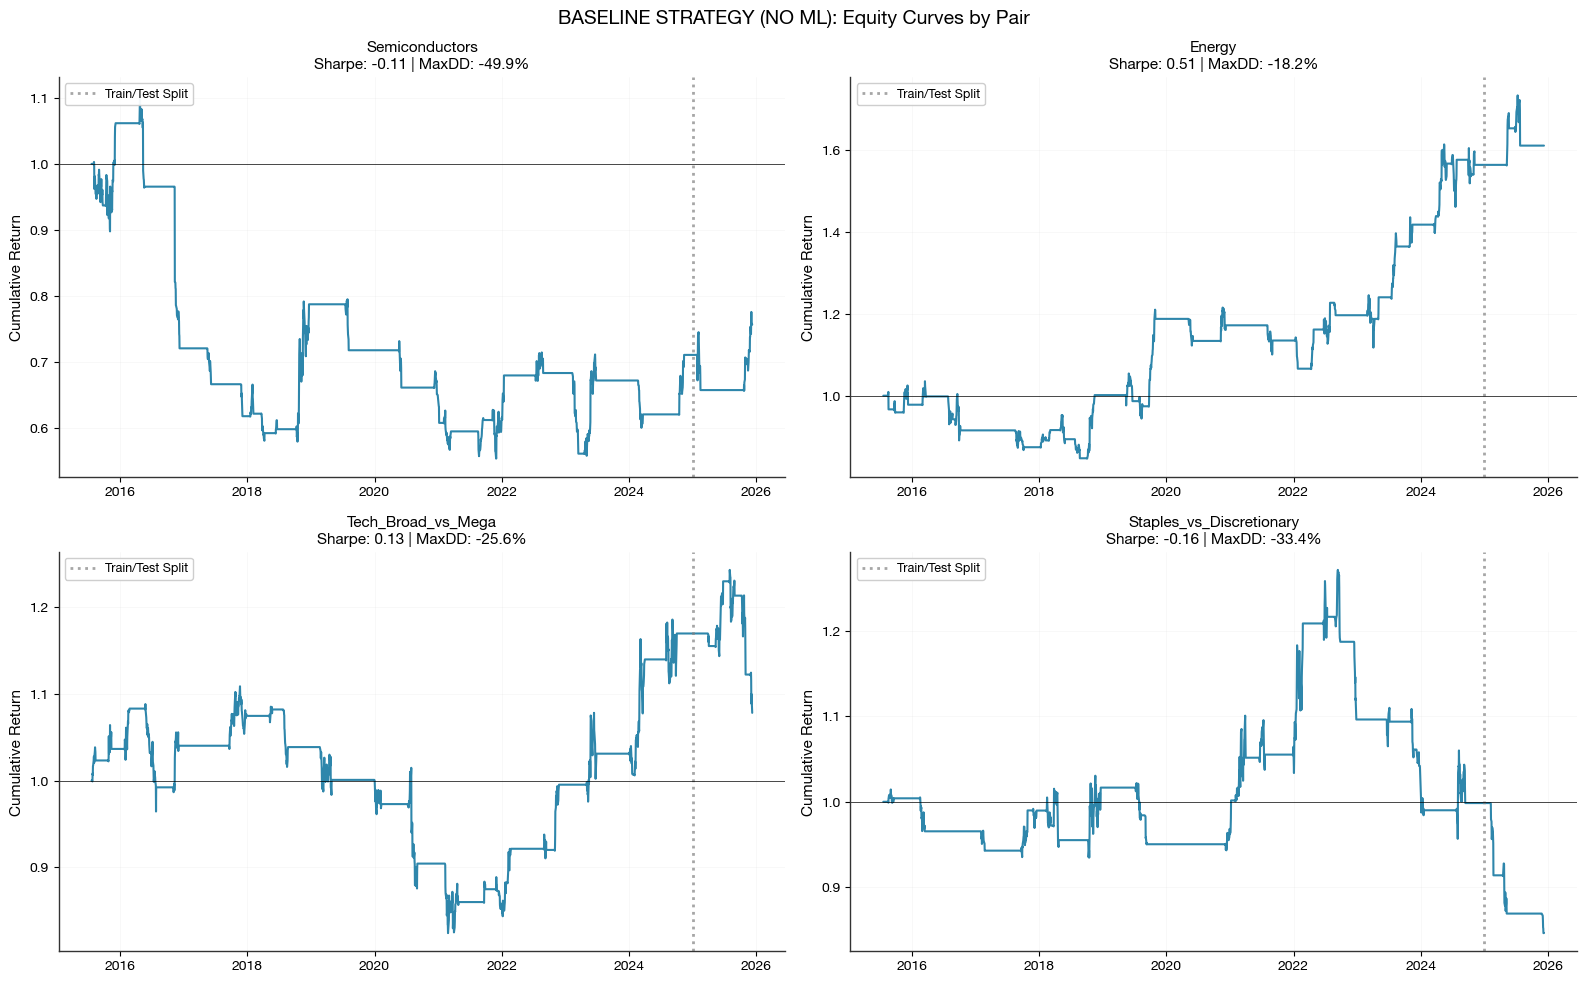

In [208]:
# =============================================================================
# BASELINE EQUITY CURVES
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (name, df) in enumerate(baseline_results.items()):
    ax = axes[idx]
    
    # Calculate cumulative returns
    cum_ret = (1 + df['ret_net']).cumprod()
    
    ax.plot(df.index, cum_ret, linewidth=1.5, color='#2E86AB')
    ax.axvline(pd.Timestamp(TRAIN_END_DATE), color='gray', linestyle=':', 
               alpha=0.7, label='Train/Test Split')
    ax.axhline(1, color='black', linewidth=0.5)
    
    # Calculate and display Sharpe
    metrics = calculate_performance_metrics(df['ret_net'])
    ax.set_title(f'{name}\nSharpe: {metrics["sharpe_ratio"]:.2f} | MaxDD: {metrics["max_drawdown"]:.1%}', 
                 fontsize=11, fontweight='bold')
    ax.set_ylabel('Cumulative Return')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('BASELINE STRATEGY (NO ML): Equity Curves by Pair', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [209]:
# =============================================================================
# BASELINE YEARLY RETURNS
# =============================================================================

print('='*70)
print('BASELINE STRATEGY: YEARLY RETURNS BY PAIR')
print('='*70)

yearly_baseline = []
for name, df in baseline_results.items():
    yearly_ret = calculate_yearly_returns(df['ret_net'])
    for year, ret in yearly_ret.items():
        yearly_baseline.append({'Pair': name, 'Year': year, 'Return': ret})

yearly_baseline_df = pd.DataFrame(yearly_baseline)
yearly_baseline_pivot = yearly_baseline_df.pivot(index='Pair', columns='Year', values='Return')

# Format as percentage
yearly_baseline_display = yearly_baseline_pivot.applymap(lambda x: f'{x:.1%}' if pd.notna(x) else '')
print(yearly_baseline_display.to_string())

# Add portfolio row
print('\n--- Portfolio (Equal-Weight) ---')
portfolio_yearly = calculate_yearly_returns(baseline_portfolio)
for year, ret in portfolio_yearly.items():
    print(f'  {year}: {ret:+.1%}')


BASELINE STRATEGY: YEARLY RETURNS BY PAIR
Year                       2015    2016    2017   2018   2019    2020   2021   2022   2023   2024    2025
Pair                                                                                                     
Energy                    -2.2%   -6.4%   -4.5%  14.6%  18.6%   -1.3%  -3.2%   5.4%  18.5%  10.3%    3.0%
Semiconductors             6.2%  -32.1%  -14.3%  27.5%  -8.9%  -10.4%  -4.3%  11.0%  -1.7%   5.8%    6.5%
Staples_vs_Discretionary   0.4%   -3.8%    2.5%   2.7%  -6.5%    1.2%  10.6%   3.0%  -6.4%  -2.7%  -15.2%
Tech_Broad_vs_Mega         3.6%    0.4%    3.3%  -3.3%  -3.6%   -9.6%  -5.7%  16.8%   3.6%  13.4%   -7.8%

--- Portfolio (Equal-Weight) ---
  2015: +2.3%
  2016: -11.0%
  2017: -3.4%
  2018: +10.4%
  2019: -0.5%
  2020: -4.9%
  2021: -0.5%
  2022: +9.4%
  2023: +3.6%
  2024: +7.0%
  2025: -3.4%


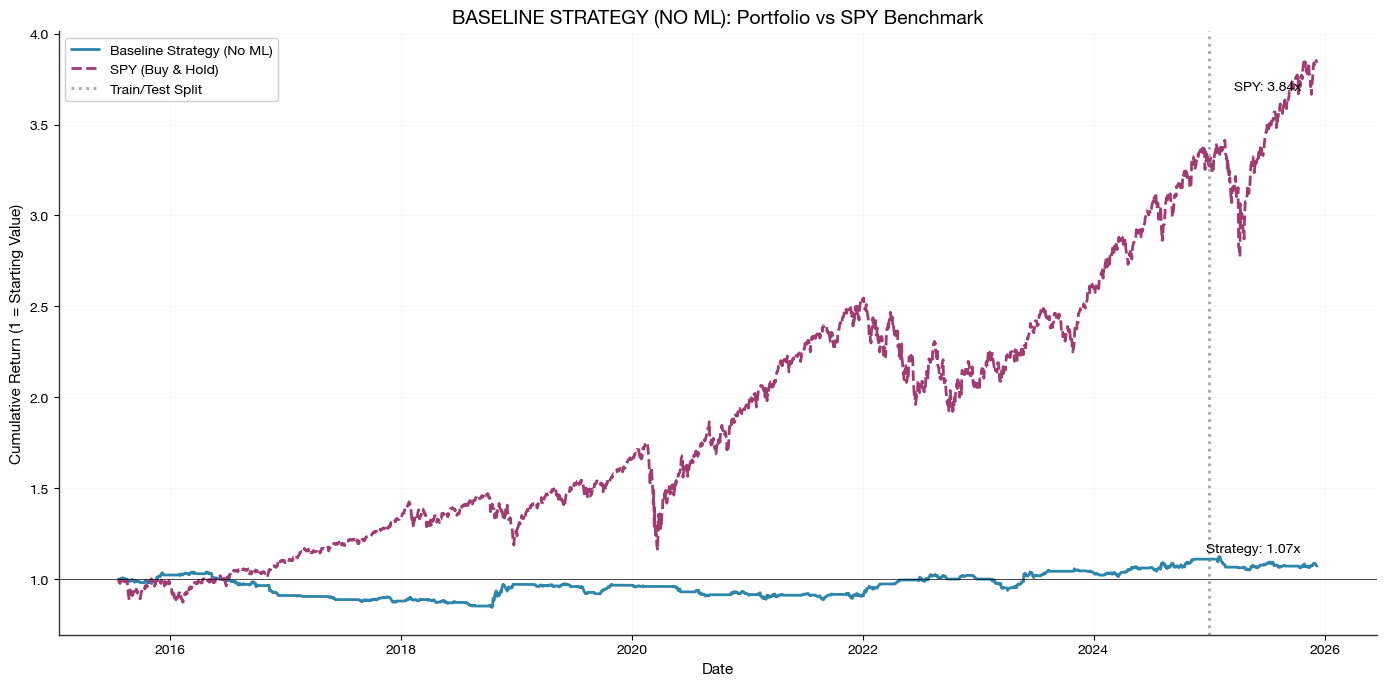


FINAL COMPARISON: BASELINE STRATEGY vs SPY

Metric                      Baseline             SPY
--------------------------------------------------
Sharpe Ratio                   0.148           0.809
Annual Return                 0.83%         14.62%
Annual Volatility             5.61%         18.08%
Max Drawdown                -18.73%        -33.72%
Total Return                  7.22%        284.05%


In [210]:
# =============================================================================
# BASELINE PORTFOLIO VS SPY
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 7))

# Calculate cumulative returns
baseline_cum = (1 + baseline_portfolio).cumprod()
spy_cum = (1 + spy_returns.reindex(baseline_portfolio.index).fillna(0)).cumprod()

ax.plot(baseline_cum.index, baseline_cum, label='Baseline Strategy (No ML)', 
        linewidth=2, color='#2E86AB')
ax.plot(spy_cum.index, spy_cum, label='SPY (Buy & Hold)', 
        linewidth=2, color='#A23B72', linestyle='--')
ax.axvline(pd.Timestamp(TRAIN_END_DATE), color='gray', linestyle=':', 
           alpha=0.7, label='Train/Test Split')
ax.axhline(1, color='black', linewidth=0.5)

# Add annotations
final_baseline = baseline_cum.iloc[-1]
final_spy = spy_cum.iloc[-1]
ax.annotate(f'Strategy: {final_baseline:.2f}x', 
            xy=(baseline_cum.index[-1], final_baseline),
            xytext=(-80, 10), textcoords='offset points', fontsize=10)
ax.annotate(f'SPY: {final_spy:.2f}x', 
            xy=(spy_cum.index[-1], final_spy),
            xytext=(-60, -20), textcoords='offset points', fontsize=10)

ax.set_title('BASELINE STRATEGY (NO ML): Portfolio vs SPY Benchmark', fontsize=14, fontweight='bold')
ax.set_ylabel('Cumulative Return (1 = Starting Value)')
ax.set_xlabel('Date')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final comparison
baseline_metrics = calculate_performance_metrics(baseline_portfolio)
spy_metrics = calculate_performance_metrics(spy_returns.reindex(baseline_portfolio.index).fillna(0))

print('\n' + '='*70)
print('FINAL COMPARISON: BASELINE STRATEGY vs SPY')
print('='*70)
print(f'\n{"Metric":<20} {"Baseline":>15} {"SPY":>15}')
print('-'*50)
print(f'{"Sharpe Ratio":<20} {baseline_metrics["sharpe_ratio"]:>15.3f} {spy_metrics["sharpe_ratio"]:>15.3f}')
print(f'{"Annual Return":<20} {baseline_metrics["ann_return"]:>14.2%} {spy_metrics["ann_return"]:>14.2%}')
print(f'{"Annual Volatility":<20} {baseline_metrics["ann_volatility"]:>14.2%} {spy_metrics["ann_volatility"]:>14.2%}')
print(f'{"Max Drawdown":<20} {baseline_metrics["max_drawdown"]:>14.2%} {spy_metrics["max_drawdown"]:>14.2%}')
print(f'{"Total Return":<20} {baseline_metrics["total_return"]:>14.2%} {spy_metrics["total_return"]:>14.2%}')
